# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [37]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime

In [38]:
import torch_geometric
from torch_geometric.data import Data, DataLoader
import torch_geometric.utils as utils

In [39]:
import networkit as nk

In [40]:
import networkx as nx

# Setting

In [41]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    data_youtube = os.path.join(_data, "youtube")
    
    
     # Create dir for train/test
    date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
    root = os.path.join(_root, "result", date_time)
    if os.path.exists(root):
        pass
    else:
        os.makedirs(root)


    ### Save plt info
    train_info_p = os.path.join(root, "train.json")
    val_info_p = os.path.join(root, "valid.json")
    test_info_p = os.path.join(root, "test.json")

    ### Save plt img
    result_plt_p = os.path.join(root, "train_plt.png")
    test_plt_p = os.path.join(root, "test_plt.png")
    sum_box_p = os.path.join(root, "sum_box.png")
        
        
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    mini_epochs = 500
    epochs = 10000

    criterion = nn.BCELoss()
    weight_node2vec = os.path.join(root, "node2vec.pth")
    weight_drbc = os.path.join(root, "drbc.pth")
    
    params_drbc = None
    params_node2vec = None

    

In [42]:
setting = Setting()

# Dataset

## Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

### Load all data

In [43]:
def load_data(path):

    edge_index = []
    between = []
    for f in os.listdir(path):
        if "score" in f:
            # ground truth of betweenness centrality
            p = os.path.join(path, f)
            between.append(p)
            pass
        else:
            p = os.path.join(path, f)
            edge_index.append(p)

    between.sort()
    edge_index.sort()
    
    return edge_index, between
    
    
synthetic, between = load_data(setting.data_synthetic)
yt, yt_score = load_data(setting.data_youtube)

### Split Data

In [44]:
from sklearn.model_selection import train_test_split


def split_data(path, x, y, replace=False):
    if os.path.exists(path) and replace:
        pass
    else:
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15)

        split = {
            "X_train": X_train,
            "X_valid": X_valid,
            "X_test": X_test,
            "y_train": y_train,
            "y_valid": y_valid,
            "y_test": y_test
        }

        with open(path, 'w') as f:
            json.dump(split, f)
            
split_data(path=setting.data_split, x=synthetic, y=between)

### Cvt 2 dataloader

In [45]:
def to_dataloader(x, y, batch):
    
    data_list = []
    for index, f in enumerate(x):
        edge_index = torch_geometric.io.read_txt_array(f, dtype=torch.long)
        edge_index = edge_index.t().contiguous()
        edge_index = utils.to_undirected(edge_index)

        row, col = edge_index  
        deg = utils.degree(col) # must use col to get degree, why?
        deg = deg.numpy()  

        vertice = []
        for d in deg:
            vertice.append([d, 1, 1])
        vertice = np.array(vertice, dtype=np.float)
        vertice = torch.from_numpy(vertice)

        ### between centrality
        bcs = []
        bc = torch_geometric.io.read_txt_array(y[index], dtype=torch.double)
        bc = bc.t().contiguous()
        row, col = bc
        bc = col
        bc = bc.numpy()
        
        bcs = torch.from_numpy(
                    np.array([[b] for b in bc], dtype=np.float))

        data = Data(x=vertice, edge_index=edge_index, y=bcs)
        data_list.append(data)

    loader = DataLoader(data_list, batch_size=batch)
    return data_list

### Cvt 2 Data

In [46]:
def to_data(x, y):
    edge_index = torch_geometric.io.read_txt_array(x, dtype=torch.long)
    edge_index = edge_index.t().contiguous()
    edge_index = utils.to_undirected(edge_index)

    row, col = edge_index  
    deg = utils.degree(col) # must use col to get degree, why?
    deg = deg.numpy()  

    vertice = []
    for d in deg:
        vertice.append([d, 1, 1])
    vertice = np.array(vertice, dtype=np.float)
    vertice = torch.from_numpy(vertice)

    ### between centrality
    bcs = []
    bc = torch_geometric.io.read_txt_array(y, dtype=torch.double)
    bc = bc.t().contiguous()
    row, col = bc
    bc = col
    bc = bc.numpy()
    bcs = torch.from_numpy(
            np.array([[b] for b in bc], dtype=np.float))

    data = Data(x=vertice, edge_index=edge_index, y=bcs)
    
    return data

#### Read data

In [47]:
f = open(setting.data_split, 'r')
data_split = json.load(f)

X_train = data_split["X_train"]
X_valid = data_split["X_valid"]
X_test = data_split["X_test"]
y_train = data_split["y_train"]
y_valid = data_split["y_valid"]
y_test = data_split["y_test"]

f.close()

#### Cvt

In [48]:
train_loader = to_dataloader(X_train, y_train, batch=1)
valid_loader = to_dataloader(X_valid, y_valid, batch=1)
test_loader = to_dataloader(X_test, y_test, batch=1)

#### Use all data

In [49]:
all_loader = to_dataloader(synthetic, between, batch=1)

#### Use YT data

In [50]:
# yt_loader = to_dataloader(yt, yt_score, batch=1)

# Model

## Hyper params

In [51]:
setting.params_drbc = dict(
    # according to source paper
    encoder_params = dict(
        c = 3,
        p = 128,
        num_layers = 5,
        device = setting.device
    ),
    decoder_params = dict(
        p = 128,
        q = 64
    )
)

# setting.params_node2vec = dict(
#     edge_index, 
#     embedding_dim, 
#     walk_length = 10, 
#     context_size,
#     p = 1,
#     q = 2
# )

## DrBC

In [52]:
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.typing import Adj, OptTensor

In [53]:
class Encoder(MessagePassing):
    def __init__(self, c, p, num_layers, device, aggr="add"):
        super(Encoder, self).__init__(aggr=aggr)
        
        self.num_layers = num_layers
        self.w_0 = nn.Linear(in_features=c, out_features=p).double()
        
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRUCell(p, p).double()

        self.device = device

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        
        
        # compute dgree
        row, col = edge_index
        deg = utils.degree(col)
        deg = torch.add(deg, 1)
        deg_inv_sqrt = torch.pow(deg, -0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        
        # h_0 = x

        # h_1
        x = self.w_0(x)
        x = self.relu(x)
        x = F.normalize(x, p=2, dim=1)
        
        h_s = [x]
        
        for i in range(self.num_layers-1):
            # internally calls the message(), aggregate() and update() functions
            x = self.propagate(edge_index, x=x, norm=norm)
            h_s.append(x)
        
        h_s = torch.stack(h_s, dim=-1)
        # Use torch.max to replace max_pooling
        z, _ = torch.max(h_s, dim=-1)
        # z = global_max_pool(h_s, torch.tensor([0], dtype=torch.long).to(self.device))
        
        return z

    def message(self, x_j, norm: OptTensor):
        """      
        In addition, tensors passed to propagate() can be mapped to the respective nodes i and j 
        by appending _i or _j to the variable name, .e.g. x_i and x_j. 
        Note that we generally refer to i as the central nodes that aggregates information, 
        and refer to j as the neighboring nodes, since this is the most common notation.
        """
  
        return x_j if norm is None else norm.view(-1, 1) * x_j
    
    
    def update(self, aggr_out, x):
        """        
        Takes in the output of aggregation as first argument 
        and any argument which was initially passed to propagate().
        """

        x = self.rnn(x, aggr_out)
        x = F.normalize(x, p=2, dim=1) 
        
        return x
    

In [54]:
class Decoder(nn.Module):
    def __init__(self, p, q):
        
        super().__init__()
        
        self.w_4 = nn.Linear(in_features=p, out_features=q).double()
        self.w_5 = nn.Linear(in_features=q, out_features=1).double()
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, z):
        z = self.w_4(z)
        z = self.relu(z)
        z = self.w_5(z)
        
        return z

In [55]:
class DrBC(nn.Module):
    def __init__(self, encoder_params, decoder_params):
        super().__init__()
        
        self.encoder = Encoder(**encoder_params)
        self.decoder = Decoder(**decoder_params)
        
        
    def forward(self, data):
        
        z = self.encoder(data)
        
        return self.decoder(z)

## Node2Vec

In [56]:
from torch_geometric.nn import Node2Vec

In [65]:
class BC_node2vec(nn.Module):
    
    def __init__(self, node2vec_params):
        super().__init__()
        
        self.node2vec = Node2Vec(**node2vec_params)
        self.mlp = nn.Linear(in_features=128, out_features=1)
        
    def forward(self, data):
        
        x = self.node2vec(data)
        x = self.mlp(x)
        
        return x

# Load model

In [66]:
def load_checkpoint(filepath, device, **params):

    if "node2vec" in filepath:
        model = BC_node2vec(**params["node2vec"])
    
    else:
        model = DrBC(**params["drbc"])
    
    model = model.to(setting.device)
    
    if os.path.exists(filepath):
        print("pretrained finded")
        checkpoint = torch.load(filepath)
        model.load_state_dict(checkpoint['model_stat'])
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        optimizer.load_state_dict(checkpoint['optimizer_stat'])

    else:
        print("use a new optimizer")
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    return model, optimizer

# Evaluation

### Top k %

In [67]:
def top_n(model, data, k):

    with torch.no_grad():

        data = data.to(setting.device)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        nodes = bc_gt.size()[0]
        k = int(nodes * k / 100)

        bc_pr = model(data)

        bc_gt = bc_gt.squeeze().to(setting.device)
        bc_pr = bc_pr.squeeze()

        gt_value, gt_indice = torch.topk(bc_gt, k)
        pr_value, pr_indice = torch.topk(bc_pr, k)

        gt_indice = set(gt_indice.cpu().numpy())
        pr_indice = set(pr_indice.cpu().numpy())

        intersect = len(gt_indice & pr_indice)
        top = intersect/k
            
       

        return top

### Tau Kendal

In [68]:
from scipy import stats

def tau_distance(model, data):
    
    
    with torch.no_grad():
 
        data = data.to(setting.device)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))

        bc_pr = model(data)

        bc_gt = bc_gt.squeeze().cpu().numpy()
        bc_pr = bc_pr.squeeze().cpu().numpy()


        tau, p_value = stats.kendalltau(bc_gt, bc_pr)
       

    return tau

### Evaluation Mode

In [69]:
def eval_model(model, data):
    
    with torch.no_grad():
        data = data.to(setting.device)
        bc_pr = model(data)

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        nodes = bc_gt.size()[0]

        # random sample 5|V| nodes
        src = (torch.rand(nodes * 5) * (nodes-1)).long()
        det = (torch.rand(nodes * 5) * (nodes-1)).long()

        y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
        y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

        y_gt = nn.Sigmoid()(y_gt)
        y_pr = nn.Sigmoid()(y_pr)

        loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)
        
        return loss.item()

In [73]:
def from_networkx(G, between_list):
    r"""Converts a :obj:`networkx.Graph` or :obj:`networkx.DiGraph` to a
    :class:`torch_geometric.data.Data` instance.

    Args:
        G (networkx.Graph or networkx.DiGraph): A networkx graph.
    """

    G = nx.convert_node_labels_to_integers(G)
    G = G.to_directed() if not nx.is_directed(G) else G
    edge_index = torch.LongTensor(list(G.edges)).t().contiguous()
   
    data = {}

    for i, (_, feat_dict) in enumerate(G.nodes(data=True)):
        for key, value in feat_dict.items():
           
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for i, (_, _, feat_dict) in enumerate(G.edges(data=True)):
        for key, value in feat_dict.items():
            data[str(key)] = [value] if i == 0 else data[str(key)] + [value]

    for key, item in data.items():
        try:
            data[key] = torch.tensor(item)
        except ValueError:
            pass

    data['edge_index'] = edge_index.view(2, -1)
    data['x'] = torch.from_numpy(
        np.array( [ [G.degree[i], 1, 1] for i in G.nodes()], dtype=np.float ) )
    data['y'] = torch.from_numpy(
        np.array( [ [b] for b in between_list ] , dtype=np.float) )
    data = torch_geometric.data.Data.from_dict(data)
    data.num_nodes = G.number_of_nodes()

    return data

# Train

In [74]:
model, optimizer = load_checkpoint(
                    setting.weight_drbc,
                    setting.device,
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)

use a new optimizer


In [75]:
nodes_cnt = 3000


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):
    
    # Draw network G from distribution D (like the power-law model)
    G = nx.generators.random_graphs.powerlaw_cluster_graph(n=nodes_cnt, m=4, p=0.05)
    # Calculate each node’s exact BC value bv, ∀v ∈ V
    betweenness = nx.algorithms.centrality.betweenness_centrality(G)
    
    # Convert betweenness dict to list
    between_list = list(betweenness.values())
    
    # Convert networkx.Graph to Pyg Data
    pyg_data = from_networkx(G, between_list)
    print("\nEpoch: {}".format(epoch+1))
    
    

    
    ### Start training
    optimizer.zero_grad()

    pyg_data = pyg_data.to(setting.device)
    bc_pr = model(pyg_data)

    bc_gt = pyg_data.y
#     bc_gt = np.array(bc_gt)
#     bc_gt = torch.from_numpy(bc_gt)
    bc_gt = torch.reshape(bc_gt, (-1, ))

    # random sample 5|V| nodes
    src = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()
    det = (torch.rand(nodes_cnt * 5) * (nodes_cnt-1)).long()

    y_gt = (bc_gt[det] - bc_gt[src]).squeeze().to(setting.device)
    y_pr = (bc_pr[det] - bc_pr[src]).squeeze()

    y_gt = nn.Sigmoid()(y_gt)
    y_pr = nn.Sigmoid()(y_pr)

    loss = nn.BCELoss(reduction="sum")(y_pr, y_gt)

    loss.backward()
    optimizer.step()
    
    
    ### Evaluation:- Train
    top1 = top_n(model, pyg_data, k=1)
    top5 = top_n(model, pyg_data, k=5)
    top10 = top_n(model, pyg_data, k=10)
    kendal = tau_distance(model, pyg_data)

    print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
            loss.item(),
            top1,
            top5,
            top10,
            kendal
    ))

    train_info["bce"].append(loss.item())
    train_info["top1"].append(top1)
    train_info["top5"].append(top5)
    train_info["top10"].append(top10)
    train_info["kendal"].append(kendal)

    with open(setting.train_info_p, 'w') as f:
        json.dump(train_info, f)



    ### Evaluation:- Synthetic
    bce_l = []
    top1_l = []
    top5_l = []
    top10_l = []
    kendal_l = []

    for data in all_loader:
        bce_l.append(eval_model(model, data))
        top1_l.append(top_n(model, data, k=1))
        top5_l.append(top_n(model, data, k=5))
        top10_l.append(top_n(model, data, k=10))
        kendal_l.append(tau_distance(model, data))
        
    bce = sum(bce_l)/len(bce_l)
    top1 = sum(top1_l)/len(top1_l)
    top5 = sum(top5_l)/len(top5_l)
    top10 = sum(top10_l)/len(top10_l)
    kendal = sum(kendal_l)/len(kendal_l)
        
    print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
        bce,
        top1,
        top5,
        top10,
        kendal
    ))

    valid_info["bce"].append(bce)
    valid_info["top1"].append(top1)
    valid_info["top5"].append(top5)
    valid_info["top10"].append(top10)
    valid_info["kendal"].append(kendal)

    with open(setting.val_info_p, 'w') as f:
        json.dump(valid_info, f)
        
    
    if top10 > top_10:
        checkpoint = {
            'model_stat': model.state_dict(),
            'optimizer_stat': optimizer.state_dict(),
        }
        torch.save(checkpoint, setting.weight_drbc)
        top_10 = top10


Epoch: 1
Train: loss = 10397.207615964773, top 1 = 0.8666666666666667, top 5 = 0.38, top 10 = 0.2733333333333333, kendal = -0.07306213182171835
Valid: loss = 17328.6852710022, top 1 = 0.04400000000000002, top 5 = 0.03066666666666668, top 10 = 0.030333333333333344, kendal = -0.36601094618923774

Epoch: 2
Train: loss = 10397.201279889807, top 1 = 0.9333333333333333, top 5 = 0.8266666666666667, top 10 = 0.7866666666666666, kendal = 0.2689683227742581
Valid: loss = 17328.67719541735, top 1 = 0.45733333333333337, top 5 = 0.1594666666666667, top 10 = 0.10700000000000001, kendal = -0.26018311929052484

Epoch: 3
Train: loss = 10397.198070454247, top 1 = 0.9, top 5 = 0.8733333333333333, top 10 = 0.8033333333333333, kendal = 0.3877910414582639
Valid: loss = 17328.671764797484, top 1 = 0.6606666666666666, top 5 = 0.42973333333333336, top 10 = 0.32506666666666656, kendal = -0.08769764619590584

Epoch: 4
Train: loss = 10397.195731161795, top 1 = 0.9333333333333333, top 5 = 0.8266666666666667, top 


Epoch: 30
Train: loss = 10397.17712883892, top 1 = 0.9333333333333333, top 5 = 0.8666666666666667, top 10 = 0.8666666666666667, kendal = 0.20972724241413807
Valid: loss = 17328.661240362868, top 1 = 0.6546666666666667, top 5 = 0.6193333333333335, top 10 = 0.5222666666666668, kendal = -0.10217743281989734

Epoch: 31
Train: loss = 10397.176959700508, top 1 = 0.9666666666666667, top 5 = 0.86, top 10 = 0.83, kendal = 0.24894653773480052
Valid: loss = 17328.661182981105, top 1 = 0.6546666666666667, top 5 = 0.6194666666666667, top 10 = 0.5219333333333334, kendal = -0.10416226712009068

Epoch: 32
Train: loss = 10397.169175573552, top 1 = 0.9666666666666667, top 5 = 0.82, top 10 = 0.8266666666666667, kendal = 0.2191228187173502
Valid: loss = 17328.66030578234, top 1 = 0.6546666666666667, top 5 = 0.6193333333333335, top 10 = 0.523, kendal = -0.10523324931652996

Epoch: 33
Train: loss = 10397.175480941598, top 1 = 0.8666666666666667, top 5 = 0.8533333333333334, top 10 = 0.8066666666666666, kend


Epoch: 59
Train: loss = 10397.161403663438, top 1 = 0.9333333333333333, top 5 = 0.9133333333333333, top 10 = 0.79, kendal = 0.2804228076025342
Valid: loss = 17328.65585308939, top 1 = 0.654, top 5 = 0.6174666666666667, top 10 = 0.4642666666666667, kendal = -0.18178532773221315

Epoch: 60
Train: loss = 10397.16693620491, top 1 = 0.9666666666666667, top 5 = 0.8466666666666667, top 10 = 0.8266666666666667, kendal = 0.28738512837612534
Valid: loss = 17328.655627690365, top 1 = 0.654, top 5 = 0.6174666666666667, top 10 = 0.461, kendal = -0.1854181983063279

Epoch: 61
Train: loss = 10397.169281157672, top 1 = 0.8666666666666667, top 5 = 0.86, top 10 = 0.8433333333333334, kendal = 0.29439146382127374
Valid: loss = 17328.656120351214, top 1 = 0.654, top 5 = 0.6173333333333334, top 10 = 0.45786666666666664, kendal = -0.18919867173434693

Epoch: 62
Train: loss = 10397.168799392826, top 1 = 0.8666666666666667, top 5 = 0.86, top 10 = 0.81, kendal = 0.28597176836723354
Valid: loss = 17328.65607474

Valid: loss = 17328.652536789927, top 1 = 0.6539999999999999, top 5 = 0.618, top 10 = 0.4205333333333334, kendal = -0.2403612669200507

Epoch: 88
Train: loss = 10397.158748733238, top 1 = 0.9, top 5 = 0.9066666666666666, top 10 = 0.8333333333333334, kendal = 0.5180291208180504
Valid: loss = 17328.65542628153, top 1 = 0.6539999999999999, top 5 = 0.6166666666666668, top 10 = 0.41753333333333337, kendal = -0.24343683670067348

Epoch: 89
Train: loss = 10397.160563061623, top 1 = 0.8666666666666667, top 5 = 0.8466666666666667, top 10 = 0.8133333333333334, kendal = 0.487839057463599
Valid: loss = 17328.65593521772, top 1 = 0.6539999999999999, top 5 = 0.6161333333333334, top 10 = 0.4166, kendal = -0.24599021671000865

Epoch: 90
Train: loss = 10397.149214728652, top 1 = 0.8666666666666667, top 5 = 0.8333333333333334, top 10 = 0.7866666666666666, kendal = 0.45686562187395796
Valid: loss = 17328.65637476078, top 1 = 0.6539999999999999, top 5 = 0.6170666666666665, top 10 = 0.4167333333333334, ken


Epoch: 116
Train: loss = 10397.15101365724, top 1 = 0.9333333333333333, top 5 = 0.8533333333333334, top 10 = 0.8233333333333334, kendal = 0.6476505501833945
Valid: loss = 17328.653316972846, top 1 = 0.6539999999999999, top 5 = 0.6182666666666667, top 10 = 0.42366666666666664, kendal = -0.21907234246849372

Epoch: 117
Train: loss = 10397.144637531543, top 1 = 0.8666666666666667, top 5 = 0.8466666666666667, top 10 = 0.84, kendal = 0.6393655662998777
Valid: loss = 17328.652507706087, top 1 = 0.6539999999999999, top 5 = 0.6196000000000002, top 10 = 0.42726666666666663, kendal = -0.2165914516236581

Epoch: 118
Train: loss = 10397.156446680172, top 1 = 0.9333333333333333, top 5 = 0.8666666666666667, top 10 = 0.83, kendal = 0.6661976214293653
Valid: loss = 17328.654128650454, top 1 = 0.6539999999999999, top 5 = 0.6192000000000001, top 10 = 0.4273333333333333, kendal = -0.2169924651596986

Epoch: 119
Train: loss = 10397.15539313287, top 1 = 0.9, top 5 = 0.8333333333333334, top 10 = 0.83333333

Valid: loss = 17328.65669005905, top 1 = 0.6546666666666667, top 5 = 0.6012, top 10 = 0.3936, kendal = -0.23381533373341334

Epoch: 145
Train: loss = 10397.149840548314, top 1 = 0.9333333333333333, top 5 = 0.86, top 10 = 0.8533333333333334, kendal = 0.6824252528620651
Valid: loss = 17328.656245147013, top 1 = 0.6546666666666667, top 5 = 0.6222666666666667, top 10 = 0.41773333333333335, kendal = -0.2139469973994799

Epoch: 146
Train: loss = 10397.156639135139, top 1 = 0.8666666666666667, top 5 = 0.8466666666666667, top 10 = 0.8566666666666667, kendal = 0.6935320662443036
Valid: loss = 17328.655373237078, top 1 = 0.6546666666666667, top 5 = 0.6285333333333334, top 10 = 0.4284666666666667, kendal = -0.20460223244648928

Epoch: 147
Train: loss = 10397.147147863252, top 1 = 0.9666666666666667, top 5 = 0.88, top 10 = 0.8333333333333334, kendal = 0.6965481827275758
Valid: loss = 17328.657136403937, top 1 = 0.6546666666666667, top 5 = 0.6264000000000001, top 10 = 0.4244666666666666, kendal = -


Epoch: 173
Train: loss = 10397.153945519403, top 1 = 0.9, top 5 = 0.8866666666666667, top 10 = 0.85, kendal = 0.6421918417250195
Valid: loss = 17328.657494134197, top 1 = 0.6546666666666666, top 5 = 0.5673333333333335, top 10 = 0.36000000000000004, kendal = -0.23865111689004467

Epoch: 174
Train: loss = 10397.147957789033, top 1 = 0.9666666666666667, top 5 = 0.9133333333333333, top 10 = 0.8633333333333333, kendal = 0.6847678114927197
Valid: loss = 17328.658187662964, top 1 = 0.6539999999999999, top 5 = 0.586, top 10 = 0.37893333333333334, kendal = -0.21843905314396214

Epoch: 175
Train: loss = 10397.138201953905, top 1 = 0.9333333333333333, top 5 = 0.8666666666666667, top 10 = 0.8666666666666667, kendal = 0.6675914193620096
Valid: loss = 17328.65931737712, top 1 = 0.6539999999999999, top 5 = 0.6165333333333334, top 10 = 0.41146666666666676, kendal = -0.16821132759885313

Epoch: 176
Train: loss = 10397.116870953538, top 1 = 0.9666666666666667, top 5 = 0.9, top 10 = 0.8433333333333334, 

Valid: loss = 17328.659035932484, top 1 = 0.6593333333333333, top 5 = 0.6458666666666666, top 10 = 0.5021333333333333, kendal = 0.012291669000466758

Epoch: 202
Train: loss = 10397.149178483294, top 1 = 0.9333333333333333, top 5 = 0.88, top 10 = 0.8533333333333334, kendal = 0.75242636434367
Valid: loss = 17328.65711099994, top 1 = 0.6593333333333333, top 5 = 0.6418666666666667, top 10 = 0.4776, kendal = -0.025915961859038477

Epoch: 203
Train: loss = 10397.143117610216, top 1 = 0.8, top 5 = 0.8866666666666667, top 10 = 0.8633333333333333, kendal = 0.7430908080471268
Valid: loss = 17328.658301846597, top 1 = 0.6586666666666667, top 5 = 0.6353333333333332, top 10 = 0.4578666666666667, kendal = -0.06534778422351137

Epoch: 204
Train: loss = 10397.14642991684, top 1 = 0.9, top 5 = 0.8666666666666667, top 10 = 0.8833333333333333, kendal = 0.694752917639213
Valid: loss = 17328.662376706914, top 1 = 0.6586666666666667, top 5 = 0.6253333333333333, top 10 = 0.4386, kendal = -0.09608970860838834


Epoch: 230
Train: loss = 10397.16286376621, top 1 = 0.9666666666666667, top 5 = 0.9266666666666666, top 10 = 0.8833333333333333, kendal = 0.7067680337890407
Valid: loss = 17328.662905948833, top 1 = 0.66, top 5 = 0.5482666666666666, top 10 = 0.3594, kendal = -0.15165754217510172

Epoch: 231
Train: loss = 10397.147341133785, top 1 = 0.9666666666666667, top 5 = 0.8733333333333333, top 10 = 0.8766666666666667, kendal = 0.7048304990552406
Valid: loss = 17328.66024449996, top 1 = 0.66, top 5 = 0.5301333333333335, top 10 = 0.34320000000000006, kendal = -0.17415041408281656

Epoch: 232
Train: loss = 10397.142492805855, top 1 = 0.9333333333333333, top 5 = 0.8933333333333333, top 10 = 0.86, kendal = 0.7399075247304657
Valid: loss = 17328.65699147727, top 1 = 0.66, top 5 = 0.5446666666666665, top 10 = 0.3576, kendal = -0.1430812829232513

Epoch: 233
Train: loss = 10397.163475996602, top 1 = 0.9666666666666667, top 5 = 0.8933333333333333, top 10 = 0.88, kendal = 0.7503341113704568
Valid: loss = 

Valid: loss = 17328.659301289357, top 1 = 0.6626666666666666, top 5 = 0.5848, top 10 = 0.4025999999999999, kendal = -0.10216588917783558

Epoch: 259
Train: loss = 10397.151150208203, top 1 = 0.9666666666666667, top 5 = 0.8866666666666667, top 10 = 0.88, kendal = 0.6673673446704457
Valid: loss = 17328.66115137613, top 1 = 0.6626666666666666, top 5 = 0.5754666666666667, top 10 = 0.3902666666666666, kendal = -0.12570746682669864

Epoch: 260
Train: loss = 10397.141102201878, top 1 = 0.9666666666666667, top 5 = 0.9266666666666666, top 10 = 0.8766666666666667, kendal = 0.6682511948427253
Valid: loss = 17328.66135032957, top 1 = 0.6633333333333333, top 5 = 0.5777333333333333, top 10 = 0.3917333333333333, kendal = -0.12682299659931984

Epoch: 261
Train: loss = 10397.146192638422, top 1 = 0.9333333333333333, top 5 = 0.92, top 10 = 0.8733333333333333, kendal = 0.6831703901300433
Valid: loss = 17328.6614426291, top 1 = 0.6633333333333333, top 5 = 0.5854666666666667, top 10 = 0.3989333333333334, k


Epoch: 287
Train: loss = 10397.124898227346, top 1 = 0.9333333333333333, top 5 = 0.8266666666666667, top 10 = 0.8533333333333334, kendal = 0.6725748582860953
Valid: loss = 17328.663827626584, top 1 = 0.6639999999999999, top 5 = 0.5750666666666666, top 10 = 0.3986, kendal = -0.05306538641061546

Epoch: 288
Train: loss = 10397.155857803376, top 1 = 0.9333333333333333, top 5 = 0.8733333333333333, top 10 = 0.8866666666666667, kendal = 0.6806944537067912
Valid: loss = 17328.66317106351, top 1 = 0.6639999999999999, top 5 = 0.6033333333333334, top 10 = 0.4339333333333333, kendal = 0.0015601146896045874

Epoch: 289
Train: loss = 10397.13437475056, top 1 = 0.9666666666666667, top 5 = 0.8733333333333333, top 10 = 0.8733333333333333, kendal = 0.6826204290318996
Valid: loss = 17328.66611474356, top 1 = 0.6639999999999999, top 5 = 0.6273333333333332, top 10 = 0.4662666666666667, kendal = 0.03051813029272522

Epoch: 290
Train: loss = 10397.153165289377, top 1 = 0.9333333333333333, top 5 = 0.9266666


Epoch: 315
Train: loss = 10397.14944009416, top 1 = 0.9333333333333333, top 5 = 0.9133333333333333, top 10 = 0.8933333333333333, kendal = 0.6814640435700788
Valid: loss = 17328.663765757883, top 1 = 0.6639999999999999, top 5 = 0.6335999999999998, top 10 = 0.4671333333333333, kendal = 0.003174528238981129

Epoch: 316
Train: loss = 10397.136775611609, top 1 = 0.8666666666666667, top 5 = 0.92, top 10 = 0.8966666666666666, kendal = 0.716487718128265
Valid: loss = 17328.664938757436, top 1 = 0.6639999999999999, top 5 = 0.618, top 10 = 0.4380666666666667, kendal = -0.04197199973328

Epoch: 317
Train: loss = 10397.1500998115, top 1 = 0.9333333333333333, top 5 = 0.8733333333333333, top 10 = 0.9, kendal = 0.7072713126597754
Valid: loss = 17328.665659844246, top 1 = 0.6639999999999999, top 5 = 0.6022666666666666, top 10 = 0.4126666666666666, kendal = -0.08392928719077147

Epoch: 318
Train: loss = 10397.130295314604, top 1 = 0.9666666666666667, top 5 = 0.8866666666666667, top 10 = 0.866666666666


Epoch: 343
Train: loss = 10397.1542626579, top 1 = 0.9333333333333333, top 5 = 0.8866666666666667, top 10 = 0.9, kendal = 0.7017859286428809
Valid: loss = 17328.667809747516, top 1 = 0.6659999999999999, top 5 = 0.6490666666666667, top 10 = 0.48613333333333336, kendal = -0.020187370807494835

Epoch: 344
Train: loss = 10397.138446924488, top 1 = 0.9333333333333333, top 5 = 0.8733333333333333, top 10 = 0.88, kendal = 0.6975516283205513
Valid: loss = 17328.666872110087, top 1 = 0.6646666666666666, top 5 = 0.6538666666666665, top 10 = 0.5035333333333335, kendal = 0.00314912049076482

Epoch: 345
Train: loss = 10397.156107262163, top 1 = 0.9666666666666667, top 5 = 0.9, top 10 = 0.8966666666666666, kendal = 0.6913913526731132
Valid: loss = 17328.66768478918, top 1 = 0.6653333333333332, top 5 = 0.6530666666666665, top 10 = 0.5013333333333333, kendal = 0.008003611388944457

Epoch: 346
Train: loss = 10397.145950501543, top 1 = 0.9333333333333333, top 5 = 0.9266666666666666, top 10 = 0.9, kendal


Epoch: 371
Train: loss = 10397.155341864102, top 1 = 0.9333333333333333, top 5 = 0.92, top 10 = 0.89, kendal = 0.690592419695454
Valid: loss = 17328.665356383484, top 1 = 0.6653333333333332, top 5 = 0.6204, top 10 = 0.4297333333333333, kendal = -0.0828106794692272

Epoch: 372
Train: loss = 10397.13416771236, top 1 = 0.9666666666666667, top 5 = 0.9133333333333333, top 10 = 0.8766666666666667, kendal = 0.5750423474491497
Valid: loss = 17328.66488941023, top 1 = 0.6659999999999999, top 5 = 0.5830666666666668, top 10 = 0.38313333333333344, kendal = -0.1353057598186304

Epoch: 373
Train: loss = 10397.157354951383, top 1 = 0.9, top 5 = 0.9066666666666666, top 10 = 0.8866666666666667, kendal = 0.6258326108702901
Valid: loss = 17328.662377877783, top 1 = 0.6659999999999999, top 5 = 0.5893333333333335, top 10 = 0.3904, kendal = -0.112988875108355

Epoch: 374
Train: loss = 10397.155711519898, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.92, kendal = 0.7600849171946205
Valid: loss = 17328

Valid: loss = 17328.665002886337, top 1 = 0.6646666666666666, top 5 = 0.6598666666666669, top 10 = 0.5482666666666667, kendal = 0.05987420417416819

Epoch: 400
Train: loss = 10397.1459698649, top 1 = 0.9333333333333333, top 5 = 0.8733333333333333, top 10 = 0.8933333333333333, kendal = 0.7543470045570746
Valid: loss = 17328.661640708353, top 1 = 0.6659999999999999, top 5 = 0.6644, top 10 = 0.5742666666666666, kendal = 0.07935224378208976

Epoch: 401
Train: loss = 10397.147067333583, top 1 = 0.9333333333333333, top 5 = 0.9066666666666666, top 10 = 0.8933333333333333, kendal = 0.7474802712015116
Valid: loss = 17328.660906956848, top 1 = 0.6653333333333332, top 5 = 0.6662666666666667, top 10 = 0.6024666666666667, kendal = 0.09820691071547641

Epoch: 402
Train: loss = 10397.148406888475, top 1 = 0.9, top 5 = 0.8866666666666667, top 10 = 0.92, kendal = 0.7465083916861176
Valid: loss = 17328.661877994637, top 1 = 0.6653333333333332, top 5 = 0.6652000000000002, top 10 = 0.6133333333333333, ken


Epoch: 428
Train: loss = 10397.156140816563, top 1 = 0.9666666666666667, top 5 = 0.9066666666666666, top 10 = 0.8933333333333333, kendal = 0.5854876069801045
Valid: loss = 17328.667155249797, top 1 = 0.6659999999999999, top 5 = 0.6483999999999999, top 10 = 0.47339999999999993, kendal = -0.043255248383009946

Epoch: 429
Train: loss = 10397.15178063547, top 1 = 0.9333333333333333, top 5 = 0.9066666666666666, top 10 = 0.9166666666666666, kendal = 0.5916149827720351
Valid: loss = 17328.667803436187, top 1 = 0.6653333333333332, top 5 = 0.6521333333333333, top 10 = 0.4791333333333334, kendal = -0.03731400680136026

Epoch: 430
Train: loss = 10397.164533109371, top 1 = 0.9333333333333333, top 5 = 0.9, top 10 = 0.91, kendal = 0.6455494053573414
Valid: loss = 17328.66717441184, top 1 = 0.6646666666666666, top 5 = 0.6587999999999999, top 10 = 0.5009333333333335, kendal = -0.008722805894512237

Epoch: 431
Train: loss = 10397.158466372974, top 1 = 0.9666666666666667, top 5 = 0.9066666666666666, to

Valid: loss = 17328.667827239926, top 1 = 0.6653333333333332, top 5 = 0.6661333333333334, top 10 = 0.5856666666666667, kendal = 0.05313180502767221

Epoch: 457
Train: loss = 10397.14040457871, top 1 = 0.8666666666666667, top 5 = 0.8933333333333333, top 10 = 0.89, kendal = 0.7366206513282205
Valid: loss = 17328.66600158134, top 1 = 0.6653333333333332, top 5 = 0.6676000000000001, top 10 = 0.5897999999999999, kendal = 0.06821574448222978

Epoch: 458
Train: loss = 10397.141317052563, top 1 = 1.0, top 5 = 0.8866666666666667, top 10 = 0.8933333333333333, kendal = 0.7378037123485606
Valid: loss = 17328.66819640853, top 1 = 0.6653333333333332, top 5 = 0.6688, top 10 = 0.5586000000000001, kendal = 0.05282406881376276

Epoch: 459
Train: loss = 10397.134931565613, top 1 = 0.9666666666666667, top 5 = 0.9133333333333333, top 10 = 0.9166666666666666, kendal = 0.7187995998666222
Valid: loss = 17328.663978771863, top 1 = 0.6653333333333332, top 5 = 0.6598666666666669, top 10 = 0.5217333333333334, kend


Epoch: 485
Train: loss = 10397.136743700274, top 1 = 0.9333333333333333, top 5 = 0.9066666666666666, top 10 = 0.8866666666666667, kendal = 0.7367482494164722
Valid: loss = 17328.665827945973, top 1 = 0.6679999999999998, top 5 = 0.6710666666666666, top 10 = 0.6138666666666667, kendal = 0.10865222644528909

Epoch: 486
Train: loss = 10397.145893237266, top 1 = 0.9333333333333333, top 5 = 0.8866666666666667, top 10 = 0.9033333333333333, kendal = 0.7526704457041237
Valid: loss = 17328.666894104223, top 1 = 0.6673333333333332, top 5 = 0.6705333333333333, top 10 = 0.6157333333333335, kendal = 0.10629995865839834

Epoch: 487
Train: loss = 10397.151808552195, top 1 = 0.9333333333333333, top 5 = 0.9, top 10 = 0.9166666666666666, kendal = 0.7522832055129488
Valid: loss = 17328.665726427625, top 1 = 0.6666666666666665, top 5 = 0.6691999999999999, top 10 = 0.6001333333333333, kendal = 0.07975473494698941

Epoch: 488
Train: loss = 10397.146605895214, top 1 = 0.9333333333333333, top 5 = 0.9066666666

Train: loss = 10397.1175778388, top 1 = 0.8666666666666667, top 5 = 0.88, top 10 = 0.8766666666666667, kendal = 0.6318848505057242
Valid: loss = 17328.66588326102, top 1 = 0.6673333333333332, top 5 = 0.6629333333333333, top 10 = 0.5423999999999999, kendal = -0.012044968993798758

Epoch: 514
Train: loss = 10397.13933538751, top 1 = 1.0, top 5 = 0.92, top 10 = 0.8966666666666666, kendal = 0.5138192730910304
Valid: loss = 17328.663455225458, top 1 = 0.6666666666666665, top 5 = 0.6404, top 10 = 0.46520000000000006, kendal = -0.08403235313729412

Epoch: 515
Train: loss = 10397.15574990509, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.92, kendal = 0.5250123374458152
Valid: loss = 17328.66335418594, top 1 = 0.6666666666666665, top 5 = 0.6416000000000001, top 10 = 0.4660000000000001, kendal = -0.08240110422084418

Epoch: 516
Train: loss = 10397.154401597507, top 1 = 0.9333333333333333, top 5 = 0.9333333333333333, top 10 = 0.9166666666666666, kendal = 0.6563085472935423
Va

Valid: loss = 17328.668529370145, top 1 = 0.6686666666666665, top 5 = 0.6104, top 10 = 0.4488666666666667, kendal = -0.02096780422751217

Epoch: 542
Train: loss = 10397.158677968708, top 1 = 1.0, top 5 = 0.8933333333333333, top 10 = 0.87, kendal = 0.661619650994776
Valid: loss = 17328.667629122294, top 1 = 0.6679999999999998, top 5 = 0.6270666666666667, top 10 = 0.48426666666666673, kendal = 0.02787733013269321

Epoch: 543
Train: loss = 10397.144951067692, top 1 = 0.9666666666666667, top 5 = 0.88, top 10 = 0.91, kendal = 0.6714420362343003
Valid: loss = 17328.665553740553, top 1 = 0.6693333333333331, top 5 = 0.6610666666666667, top 10 = 0.5468666666666666, kendal = 0.0878380476095219

Epoch: 544
Train: loss = 10397.156266726484, top 1 = 0.9666666666666667, top 5 = 0.9133333333333333, top 10 = 0.9133333333333333, kendal = 0.6818672890963655
Valid: loss = 17328.66802169281, top 1 = 0.6693333333333331, top 5 = 0.6790666666666667, top 10 = 0.6046666666666667, kendal = 0.13019395345735812




Epoch: 570
Train: loss = 10397.14467733523, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.89, kendal = 0.7464150272312994
Valid: loss = 17328.660281173892, top 1 = 0.6679999999999998, top 5 = 0.6737333333333332, top 10 = 0.5750000000000001, kendal = 0.06083136627325466

Epoch: 571
Train: loss = 10397.138917504673, top 1 = 0.9333333333333333, top 5 = 0.9, top 10 = 0.9266666666666666, kendal = 0.7392855396243192
Valid: loss = 17328.666216690213, top 1 = 0.6679999999999998, top 5 = 0.6778666666666667, top 10 = 0.6133333333333334, kendal = 0.10337156497966261

Epoch: 572
Train: loss = 10397.164023132309, top 1 = 0.9333333333333333, top 5 = 0.92, top 10 = 0.9066666666666666, kendal = 0.7391557185728576
Valid: loss = 17328.666397681354, top 1 = 0.6679999999999998, top 5 = 0.6764, top 10 = 0.6283333333333334, kendal = 0.1211836447289458

Epoch: 573
Train: loss = 10397.151024177212, top 1 = 0.9333333333333333, top 5 = 0.92, top 10 = 0.9133333333333333, kendal = 0.76708013

Valid: loss = 17328.66209033363, top 1 = 0.6693333333333331, top 5 = 0.6633333333333334, top 10 = 0.5363999999999999, kendal = -0.011509085817163433

Epoch: 599
Train: loss = 10397.161234666055, top 1 = 0.8666666666666667, top 5 = 0.9266666666666666, top 10 = 0.8933333333333333, kendal = 0.6866564410359008
Valid: loss = 17328.662915718982, top 1 = 0.6693333333333331, top 5 = 0.67, top 10 = 0.553, kendal = -0.0018548136293925453

Epoch: 600
Train: loss = 10397.14101034015, top 1 = 0.9666666666666667, top 5 = 0.8866666666666667, top 10 = 0.9233333333333333, kendal = 0.7109983327775925
Valid: loss = 17328.66355804613, top 1 = 0.6693333333333331, top 5 = 0.6716, top 10 = 0.5617999999999999, kendal = 0.005008463025938521

Epoch: 601
Train: loss = 10397.15343734375, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.92, kendal = 0.7529367566966767
Valid: loss = 17328.664184146564, top 1 = 0.6679999999999998, top 5 = 0.6715999999999999, top 10 = 0.5987333333333333, kendal = 0.


Epoch: 627
Train: loss = 10397.149880193527, top 1 = 0.9333333333333333, top 5 = 0.9133333333333333, top 10 = 0.91, kendal = 0.7224621540513504
Valid: loss = 17328.663705251787, top 1 = 0.6679999999999998, top 5 = 0.6674666666666667, top 10 = 0.5478666666666666, kendal = 0.029757028739081155

Epoch: 628
Train: loss = 10397.140150550043, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.9233333333333333, kendal = 0.7115558519506503
Valid: loss = 17328.667237216905, top 1 = 0.6679999999999998, top 5 = 0.6685333333333333, top 10 = 0.5514, kendal = 0.03543672467826899

Epoch: 629
Train: loss = 10397.147984039262, top 1 = 0.9666666666666667, top 5 = 0.9066666666666666, top 10 = 0.9, kendal = 0.7213431143714572
Valid: loss = 17328.661763344477, top 1 = 0.6679999999999998, top 5 = 0.6648000000000001, top 10 = 0.5406666666666665, kendal = 0.019089780622791222

Epoch: 630
Train: loss = 10397.147756588596, top 1 = 0.9333333333333333, top 5 = 0.9066666666666666, top 10 = 0.95333

Valid: loss = 17328.66668844906, top 1 = 0.6693333333333331, top 5 = 0.6732, top 10 = 0.6025333333333334, kendal = 0.07765792625191704

Epoch: 656
Train: loss = 10397.143643352141, top 1 = 0.9, top 5 = 0.9266666666666666, top 10 = 0.9133333333333333, kendal = 0.7148894075803045
Valid: loss = 17328.668096067962, top 1 = 0.6679999999999998, top 5 = 0.67, top 10 = 0.5515333333333333, kendal = -0.0057229099153163964

Epoch: 657
Train: loss = 10397.154669249436, top 1 = 0.9, top 5 = 0.92, top 10 = 0.93, kendal = 0.5777610314549294
Valid: loss = 17328.66864603326, top 1 = 0.6679999999999998, top 5 = 0.6484000000000001, top 10 = 0.47893333333333327, kendal = -0.07780326198573048

Epoch: 658
Train: loss = 10397.156624559208, top 1 = 0.9666666666666667, top 5 = 0.9133333333333333, top 10 = 0.9066666666666666, kendal = 0.4823367789263088
Valid: loss = 17328.66801774768, top 1 = 0.6686666666666665, top 5 = 0.6291999999999998, top 10 = 0.44426666666666675, kendal = -0.11232341935053677

Epoch: 659


Epoch: 684
Train: loss = 10397.141348279387, top 1 = 0.9333333333333333, top 5 = 0.8933333333333333, top 10 = 0.9066666666666666, kendal = 0.3785759697677003
Valid: loss = 17328.664773472494, top 1 = 0.6693333333333331, top 5 = 0.6077333333333333, top 10 = 0.41080000000000017, kendal = -0.14872026138561048

Epoch: 685
Train: loss = 10397.149280179663, top 1 = 0.9333333333333333, top 5 = 0.8866666666666667, top 10 = 0.9033333333333333, kendal = 0.41516950094475935
Valid: loss = 17328.66331798534, top 1 = 0.6693333333333331, top 5 = 0.6226666666666667, top 10 = 0.43240000000000006, kendal = -0.1370925171701007

Epoch: 686
Train: loss = 10397.162570147284, top 1 = 0.9, top 5 = 0.9333333333333333, top 10 = 0.9266666666666666, kendal = 0.6030316772257419
Valid: loss = 17328.66497803298, top 1 = 0.6693333333333331, top 5 = 0.6652000000000001, top 10 = 0.5147333333333333, kendal = -0.076367849569914

Epoch: 687
Train: loss = 10397.137070634486, top 1 = 0.9333333333333333, top 5 = 0.906666666


Epoch: 712
Train: loss = 10397.149341326287, top 1 = 0.9666666666666667, top 5 = 0.9, top 10 = 0.9133333333333333, kendal = 0.7236163165499611
Valid: loss = 17328.667754735015, top 1 = 0.6693333333333331, top 5 = 0.6701333333333331, top 10 = 0.5667333333333333, kendal = 0.013496539307861571

Epoch: 713
Train: loss = 10397.15841394189, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9266666666666666, kendal = 0.7345079470934756
Valid: loss = 17328.66670671888, top 1 = 0.6693333333333331, top 5 = 0.6658666666666665, top 10 = 0.5336666666666667, kendal = -0.028704700940188045

Epoch: 714
Train: loss = 10397.145708863822, top 1 = 0.8666666666666667, top 5 = 0.8933333333333333, top 10 = 0.9, kendal = 0.7010043347782594
Valid: loss = 17328.6648788322, top 1 = 0.6693333333333331, top 5 = 0.6302666666666666, top 10 = 0.46546666666666675, kendal = -0.10326132426485297

Epoch: 715
Train: loss = 10397.151253622264, top 1 = 0.9, top 5 = 0.9133333333333333, top 10 = 0.9133333333

Valid: loss = 17328.667489743824, top 1 = 0.6699999999999998, top 5 = 0.6713333333333334, top 10 = 0.5512666666666667, kendal = -0.023176848703073953

Epoch: 741
Train: loss = 10397.151412560132, top 1 = 0.9666666666666667, top 5 = 0.8866666666666667, top 10 = 0.92, kendal = 0.6870921418250528
Valid: loss = 17328.66890307552, top 1 = 0.6713333333333332, top 5 = 0.6584, top 10 = 0.5098666666666668, kendal = -0.06405198373007936

Epoch: 742
Train: loss = 10397.15991610934, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9233333333333333, kendal = 0.671673224408136
Valid: loss = 17328.670273386764, top 1 = 0.6706666666666666, top 5 = 0.6525333333333333, top 10 = 0.4944666666666668, kendal = -0.0813810228712409

Epoch: 743
Train: loss = 10397.142226012431, top 1 = 0.9333333333333333, top 5 = 0.9133333333333333, top 10 = 0.9233333333333333, kendal = 0.6279817717016783
Valid: loss = 17328.672598806075, top 1 = 0.6706666666666666, top 5 = 0.6369333333333332, top 10 = 0.4691


Epoch: 769
Train: loss = 10397.14455646533, top 1 = 0.9333333333333333, top 5 = 0.92, top 10 = 0.9133333333333333, kendal = 0.6335196176503279
Valid: loss = 17328.671711801384, top 1 = 0.6713333333333331, top 5 = 0.5982666666666668, top 10 = 0.4183333333333333, kendal = -0.12179750616790025

Epoch: 770
Train: loss = 10397.14290877727, top 1 = 0.9666666666666667, top 5 = 0.9266666666666666, top 10 = 0.9166666666666666, kendal = 0.6010345670779149
Valid: loss = 17328.666834517287, top 1 = 0.6726666666666665, top 5 = 0.5666666666666668, top 10 = 0.3861333333333334, kendal = -0.14208576648663068

Epoch: 771
Train: loss = 10397.155219192315, top 1 = 0.9666666666666667, top 5 = 0.9266666666666666, top 10 = 0.9266666666666666, kendal = 0.7157403578970768
Valid: loss = 17328.6717353601, top 1 = 0.6733333333333332, top 5 = 0.628, top 10 = 0.46613333333333345, kendal = -0.08173166900046676

Epoch: 772
Train: loss = 10397.141986897132, top 1 = 0.9333333333333333, top 5 = 0.9066666666666666, top 

Valid: loss = 17328.668814337994, top 1 = 0.6713333333333331, top 5 = 0.5945333333333332, top 10 = 0.40033333333333326, kendal = -0.14679846902713878

Epoch: 798
Train: loss = 10397.14334313021, top 1 = 0.8333333333333334, top 5 = 0.88, top 10 = 0.8966666666666666, kendal = 0.4027089029676559
Valid: loss = 17328.66794663166, top 1 = 0.6713333333333331, top 5 = 0.5462666666666666, top 10 = 0.3572666666666668, kendal = -0.17811250783490032

Epoch: 799
Train: loss = 10397.153545298013, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.91, kendal = 0.5306110925864177
Valid: loss = 17328.667250385355, top 1 = 0.6713333333333331, top 5 = 0.5823999999999999, top 10 = 0.3904666666666667, kendal = -0.15011084883643394

Epoch: 800
Train: loss = 10397.153278407648, top 1 = 1.0, top 5 = 0.92, top 10 = 0.9366666666666666, kendal = 0.7354402578637323
Valid: loss = 17328.670961756878, top 1 = 0.6713333333333331, top 5 = 0.6489333333333335, top 10 = 0.48686666666666667, kendal = -0.07489704340868172

Valid: loss = 17328.669548079415, top 1 = 0.6713333333333331, top 5 = 0.6028000000000001, top 10 = 0.4093333333333333, kendal = -0.14759008868440354

Epoch: 826
Train: loss = 10397.158560071955, top 1 = 0.9, top 5 = 0.9466666666666667, top 10 = 0.9366666666666666, kendal = 0.6277430254529288
Valid: loss = 17328.672826311853, top 1 = 0.6713333333333331, top 5 = 0.6185333333333335, top 10 = 0.42940000000000006, kendal = -0.13023564179502567

Epoch: 827
Train: loss = 10397.130756226768, top 1 = 0.9666666666666667, top 5 = 0.8933333333333333, top 10 = 0.9533333333333334, kendal = 0.6959315327331332
Valid: loss = 17328.670875399177, top 1 = 0.6713333333333331, top 5 = 0.6330666666666666, top 10 = 0.45853333333333346, kendal = -0.10311943455357736

Epoch: 828
Train: loss = 10397.13031542549, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9166666666666666, kendal = 0.7191432699788819
Valid: loss = 17328.668532632608, top 1 = 0.6713333333333331, top 5 = 0.6321333333333333, 


Epoch: 854
Train: loss = 10397.15102493117, top 1 = 0.8666666666666667, top 5 = 0.92, top 10 = 0.8933333333333333, kendal = 0.6979784372568634
Valid: loss = 17328.66669208922, top 1 = 0.6713333333333331, top 5 = 0.650933333333333, top 10 = 0.4799333333333334, kendal = -0.09503642061745683

Epoch: 855
Train: loss = 10397.144882111785, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.9266666666666666, kendal = 0.7299273091030343
Valid: loss = 17328.667915460406, top 1 = 0.6713333333333331, top 5 = 0.6481333333333333, top 10 = 0.4748666666666668, kendal = -0.09892975928519038

Epoch: 856
Train: loss = 10397.121705725149, top 1 = 1.0, top 5 = 0.94, top 10 = 0.9333333333333333, kendal = 0.7020051128153829
Valid: loss = 17328.667709035333, top 1 = 0.6713333333333331, top 5 = 0.6352, top 10 = 0.45886666666666664, kendal = -0.11055550310062015

Epoch: 857
Train: loss = 10397.16042523408, top 1 = 0.9333333333333333, top 5 = 0.9333333333333333, top 10 = 0.9433333333333334, kendal = 0.721034

Valid: loss = 17328.660976922376, top 1 = 0.6739999999999998, top 5 = 0.5706666666666665, top 10 = 0.39440000000000003, kendal = -0.1434760018670401

Epoch: 883
Train: loss = 10397.158525916915, top 1 = 1.0, top 5 = 0.94, top 10 = 0.9333333333333333, kendal = 0.7226239857730354
Valid: loss = 17328.66258520616, top 1 = 0.6746666666666665, top 5 = 0.6583999999999999, top 10 = 0.5108666666666667, kendal = -0.055312225111689005

Epoch: 884
Train: loss = 10397.15403772194, top 1 = 0.9333333333333333, top 5 = 0.92, top 10 = 0.9333333333333333, kendal = 0.724001778370568
Valid: loss = 17328.664424759383, top 1 = 0.6733333333333332, top 5 = 0.6754666666666667, top 10 = 0.5935999999999998, kendal = 0.02661464559578582

Epoch: 885
Train: loss = 10397.14434930171, top 1 = 0.9666666666666667, top 5 = 0.9133333333333333, top 10 = 0.9333333333333333, kendal = 0.7191490496832277
Valid: loss = 17328.666486489525, top 1 = 0.6719999999999999, top 5 = 0.6728000000000001, top 10 = 0.6173333333333333, kend


Epoch: 911
Train: loss = 10397.137530309757, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.9133333333333333, kendal = 0.5885215071690564
Valid: loss = 17328.668422320137, top 1 = 0.6733333333333332, top 5 = 0.5974666666666667, top 10 = 0.41206666666666675, kendal = -0.15401258385010333

Epoch: 912
Train: loss = 10397.134655889051, top 1 = 0.9666666666666667, top 5 = 0.9066666666666666, top 10 = 0.9333333333333333, kendal = 0.5943198844059131
Valid: loss = 17328.667261113427, top 1 = 0.6733333333333332, top 5 = 0.5978666666666665, top 10 = 0.4114666666666667, kendal = -0.15450474094818964

Epoch: 913
Train: loss = 10397.139277167087, top 1 = 0.9, top 5 = 0.9066666666666666, top 10 = 0.9266666666666666, kendal = 0.6598639546515505
Valid: loss = 17328.667451601683, top 1 = 0.6726666666666665, top 5 = 0.6234666666666666, top 10 = 0.44273333333333326, kendal = -0.13051768753750748

Epoch: 914
Train: loss = 10397.134410401704, top 1 = 0.9666666666666667, top 5 = 0.9066666666666666, t


Epoch: 939
Train: loss = 10397.146188133875, top 1 = 0.9, top 5 = 0.96, top 10 = 0.9066666666666666, kendal = 0.7553851283761254
Valid: loss = 17328.669344998183, top 1 = 0.6746666666666665, top 5 = 0.6784, top 10 = 0.6006666666666668, kendal = 0.00447377475495099

Epoch: 940
Train: loss = 10397.144913185963, top 1 = 0.9, top 5 = 0.94, top 10 = 0.91, kendal = 0.7785853062131821
Valid: loss = 17328.66968245754, top 1 = 0.6753333333333331, top 5 = 0.6770666666666668, top 10 = 0.5554666666666666, kendal = -0.0396671974394879

Epoch: 941
Train: loss = 10397.147861099791, top 1 = 0.9, top 5 = 0.9266666666666666, top 10 = 0.9233333333333333, kendal = 0.671190396798933
Valid: loss = 17328.668947179238, top 1 = 0.6753333333333331, top 5 = 0.634, top 10 = 0.45640000000000003, kendal = -0.1090638767753551

Epoch: 942
Train: loss = 10397.13461548907, top 1 = 0.9333333333333333, top 5 = 0.9133333333333333, top 10 = 0.9033333333333333, kendal = 0.5237150161164833
Valid: loss = 17328.66744798083, t

Valid: loss = 17328.67133450606, top 1 = 0.6739999999999999, top 5 = 0.5923999999999999, top 10 = 0.3959333333333334, kendal = -0.1649003400680136

Epoch: 968
Train: loss = 10397.161336904868, top 1 = 0.9, top 5 = 0.9266666666666666, top 10 = 0.9166666666666666, kendal = 0.5689554295876403
Valid: loss = 17328.671602735183, top 1 = 0.6739999999999999, top 5 = 0.5949333333333333, top 10 = 0.40086666666666665, kendal = -0.1583628085617124

Epoch: 969
Train: loss = 10397.141370498488, top 1 = 1.0, top 5 = 0.94, top 10 = 0.9233333333333333, kendal = 0.6403667889296432
Valid: loss = 17328.67089524811, top 1 = 0.6746666666666666, top 5 = 0.6006666666666667, top 10 = 0.4115999999999999, kendal = -0.1453733893445356

Epoch: 970
Train: loss = 10397.135797283434, top 1 = 0.9, top 5 = 0.9466666666666667, top 10 = 0.93, kendal = 0.7168740691341559
Valid: loss = 17328.668086702084, top 1 = 0.6766666666666665, top 5 = 0.6113333333333332, top 10 = 0.4306000000000001, kendal = -0.1240924451556978

Epoc

Valid: loss = 17328.66777522987, top 1 = 0.6739999999999998, top 5 = 0.6148000000000001, top 10 = 0.4251333333333333, kendal = -0.13846999266519971

Epoch: 996
Train: loss = 10397.138569264233, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.92, kendal = 0.7404570412359676
Valid: loss = 17328.667149391506, top 1 = 0.6739999999999998, top 5 = 0.6721333333333331, top 10 = 0.5170666666666667, kendal = -0.07771694605587784

Epoch: 997
Train: loss = 10397.143919619371, top 1 = 1.0, top 5 = 0.94, top 10 = 0.95, kendal = 0.7767113482271868
Valid: loss = 17328.66895525183, top 1 = 0.6739999999999998, top 5 = 0.6788000000000001, top 10 = 0.5662, kendal = -0.03392389944655597

Epoch: 998
Train: loss = 10397.156588401076, top 1 = 0.9666666666666667, top 5 = 0.92, top 10 = 0.9566666666666667, kendal = 0.758381238190508
Valid: loss = 17328.667373801825, top 1 = 0.6739999999999998, top 5 = 0.6785333333333334, top 10 = 0.5663999999999999, kendal = -0.02852471827698873

Epoch: 999
T


Epoch: 1024
Train: loss = 10397.160175043191, top 1 = 0.9333333333333333, top 5 = 0.92, top 10 = 0.9333333333333333, kendal = 0.6917576970101145
Valid: loss = 17328.664428168187, top 1 = 0.6753333333333331, top 5 = 0.6451999999999999, top 10 = 0.45253333333333334, kendal = -0.123270350070014

Epoch: 1025
Train: loss = 10397.148842365898, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9233333333333333, kendal = 0.7451137045681894
Valid: loss = 17328.66718612388, top 1 = 0.6759999999999999, top 5 = 0.6699999999999999, top 10 = 0.4995333333333333, kendal = -0.0908801973728079

Epoch: 1026
Train: loss = 10397.12154373971, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.93, kendal = 0.734647993775703
Valid: loss = 17328.664926343903, top 1 = 0.6759999999999999, top 5 = 0.6793333333333335, top 10 = 0.5488, kendal = -0.055394049476561985

Epoch: 1027
Train: loss = 10397.14684941555, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.9333333333333333, 


Epoch: 1052
Train: loss = 10397.119164079928, top 1 = 0.9, top 5 = 0.92, top 10 = 0.9333333333333333, kendal = 0.752482827609203
Valid: loss = 17328.66494981835, top 1 = 0.6759999999999998, top 5 = 0.6736000000000001, top 10 = 0.5278666666666666, kendal = -0.06692746015869841

Epoch: 1053
Train: loss = 10397.133073652498, top 1 = 0.9333333333333333, top 5 = 0.9333333333333333, top 10 = 0.9266666666666666, kendal = 0.741136378792931
Valid: loss = 17328.66705408441, top 1 = 0.6753333333333331, top 5 = 0.6758666666666666, top 10 = 0.5486666666666667, kendal = -0.05342458891778356

Epoch: 1054
Train: loss = 10397.154962980085, top 1 = 0.9333333333333333, top 5 = 0.9133333333333333, top 10 = 0.9266666666666666, kendal = 0.7596981215960876
Valid: loss = 17328.66845141008, top 1 = 0.6753333333333331, top 5 = 0.6744, top 10 = 0.5271333333333333, kendal = -0.07354746149229846

Epoch: 1055
Train: loss = 10397.160421883347, top 1 = 0.9666666666666667, top 5 = 0.9266666666666666, top 10 = 0.95, k


Epoch: 1080
Train: loss = 10397.150420076323, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9466666666666667, kendal = 0.6802596421029231
Valid: loss = 17328.666454687656, top 1 = 0.6753333333333331, top 5 = 0.6372, top 10 = 0.44673333333333337, kendal = -0.13120078949123162

Epoch: 1081
Train: loss = 10397.12163968669, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.92, kendal = 0.7091835056129822
Valid: loss = 17328.66673217764, top 1 = 0.6753333333333331, top 5 = 0.6526666666666666, top 10 = 0.46773333333333333, kendal = -0.11768269387210778

Epoch: 1082
Train: loss = 10397.153618804707, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.96, kendal = 0.7566579971101478
Valid: loss = 17328.671731638806, top 1 = 0.6753333333333331, top 5 = 0.6741333333333334, top 10 = 0.5160000000000001, kendal = -0.08578330066013203

Epoch: 1083
Train: loss = 10397.160659185465, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9266666666666


Epoch: 1108
Train: loss = 10397.143611486345, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.9266666666666666, kendal = 0.670597310214516
Valid: loss = 17328.66965977558, top 1 = 0.6753333333333331, top 5 = 0.6623999999999999, top 10 = 0.48426666666666673, kendal = -0.11491221444288861

Epoch: 1109
Train: loss = 10397.144720070944, top 1 = 0.9, top 5 = 0.94, top 10 = 0.9333333333333333, kendal = 0.7246206513282205
Valid: loss = 17328.66708275324, top 1 = 0.6753333333333331, top 5 = 0.6685333333333332, top 10 = 0.5006666666666667, kendal = -0.10214734680269387

Epoch: 1110
Train: loss = 10397.148041857481, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9366666666666666, kendal = 0.7487393575636323
Valid: loss = 17328.66871772499, top 1 = 0.6753333333333331, top 5 = 0.6722666666666667, top 10 = 0.5169999999999999, kendal = -0.08708170434086818

Epoch: 1111
Train: loss = 10397.153240184829, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.93333


Epoch: 1136
Train: loss = 10397.161669133638, top 1 = 0.9333333333333333, top 5 = 0.9, top 10 = 0.9233333333333333, kendal = 0.6820864732688674
Valid: loss = 17328.663399184417, top 1 = 0.6759999999999998, top 5 = 0.6704, top 10 = 0.5867333333333334, kendal = -0.01066118823764753

Epoch: 1137
Train: loss = 10397.16901972229, top 1 = 0.9333333333333333, top 5 = 0.92, top 10 = 0.9433333333333334, kendal = 0.682915638546182
Valid: loss = 17328.664932342923, top 1 = 0.6759999999999998, top 5 = 0.6686666666666669, top 10 = 0.6066, kendal = 0.012085974528238985

Epoch: 1138
Train: loss = 10397.163758436951, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9266666666666666, kendal = 0.7211541624986106
Valid: loss = 17328.666509190134, top 1 = 0.6759999999999998, top 5 = 0.6686666666666667, top 10 = 0.5830000000000001, kendal = -0.021800850836834033

Epoch: 1139
Train: loss = 10397.126746901027, top 1 = 0.9666666666666667, top 5 = 0.9066666666666666, top 10 = 0.9466666666666

Valid: loss = 17328.67131212423, top 1 = 0.6759999999999998, top 5 = 0.6286666666666664, top 10 = 0.4347333333333333, kendal = -0.14053901446956057

Epoch: 1165
Train: loss = 10397.123419523414, top 1 = 0.9666666666666667, top 5 = 0.9266666666666666, top 10 = 0.9233333333333333, kendal = 0.6488176058686229
Valid: loss = 17328.670440486727, top 1 = 0.6759999999999998, top 5 = 0.6379999999999998, top 10 = 0.4465333333333334, kendal = -0.1324036220577449

Epoch: 1166
Train: loss = 10397.123977160143, top 1 = 0.9666666666666667, top 5 = 0.9266666666666666, top 10 = 0.93, kendal = 0.7007993775703013
Valid: loss = 17328.67083235806, top 1 = 0.6759999999999998, top 5 = 0.6501333333333332, top 10 = 0.4637333333333335, kendal = -0.11983736480629462

Epoch: 1167
Train: loss = 10397.14695897709, top 1 = 0.9, top 5 = 0.94, top 10 = 0.93, kendal = 0.7256467711459375
Valid: loss = 17328.67068585181, top 1 = 0.6759999999999998, top 5 = 0.6638666666666667, top 10 = 0.4893333333333334, kendal = -0.1018


Epoch: 1193
Train: loss = 10397.152206465997, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9233333333333333, kendal = 0.7641173724574858
Valid: loss = 17328.66216907099, top 1 = 0.6759999999999998, top 5 = 0.6731999999999999, top 10 = 0.5804000000000001, kendal = -0.040326150563446024

Epoch: 1194
Train: loss = 10397.162770452655, top 1 = 0.9333333333333333, top 5 = 0.96, top 10 = 0.9166666666666666, kendal = 0.7772284094698232
Valid: loss = 17328.66475220654, top 1 = 0.6759999999999998, top 5 = 0.6716, top 10 = 0.5930000000000001, kendal = -0.03187055544442222

Epoch: 1195
Train: loss = 10397.156044188578, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9166666666666666, kendal = 0.7601991775036122
Valid: loss = 17328.66556535239, top 1 = 0.6746666666666665, top 5 = 0.6709333333333333, top 10 = 0.5769333333333332, kendal = -0.05108437687537507

Epoch: 1196
Train: loss = 10397.154613788418, top 1 = 0.9333333333333333, top 5 = 0.9066666666666666, top 10 = 0.9


Epoch: 1221
Train: loss = 10397.156218881028, top 1 = 0.9666666666666667, top 5 = 0.9133333333333333, top 10 = 0.9233333333333333, kendal = 0.6077665888629543
Valid: loss = 17328.664100109916, top 1 = 0.6766666666666665, top 5 = 0.5957333333333333, top 10 = 0.4073333333333334, kendal = -0.16123122224444889

Epoch: 1222
Train: loss = 10397.134391935666, top 1 = 1.0, top 5 = 0.8866666666666667, top 10 = 0.9266666666666666, kendal = 0.6677247971546071
Valid: loss = 17328.667759201424, top 1 = 0.6766666666666665, top 5 = 0.6245333333333333, top 10 = 0.4411333333333334, kendal = -0.13857620057344805

Epoch: 1223
Train: loss = 10397.116336286215, top 1 = 1.0, top 5 = 0.94, top 10 = 0.9366666666666666, kendal = 0.7278252750916971
Valid: loss = 17328.66492630432, top 1 = 0.6773333333333333, top 5 = 0.6541333333333335, top 10 = 0.48873333333333335, kendal = -0.10724649996666001

Epoch: 1224
Train: loss = 10397.130651678195, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.9266666666666666,

Valid: loss = 17328.667038448995, top 1 = 0.6766666666666664, top 5 = 0.6401333333333332, top 10 = 0.46193333333333336, kendal = -0.12567510302060414

Epoch: 1250
Train: loss = 10397.122446639596, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9566666666666667, kendal = 0.6930332332999889
Valid: loss = 17328.668860339498, top 1 = 0.6766666666666664, top 5 = 0.6561333333333333, top 10 = 0.48666666666666664, kendal = -0.10882829899313197

Epoch: 1251
Train: loss = 10397.135450616239, top 1 = 0.9333333333333333, top 5 = 0.9866666666666667, top 10 = 0.9266666666666666, kendal = 0.7056916750027787
Valid: loss = 17328.66824178263, top 1 = 0.6759999999999998, top 5 = 0.6733333333333335, top 10 = 0.5320666666666666, kendal = -0.07346393545375743

Epoch: 1252
Train: loss = 10397.143779447357, top 1 = 0.9333333333333333, top 5 = 0.9533333333333334, top 10 = 0.94, kendal = 0.7177343558964099
Valid: loss = 17328.664598193674, top 1 = 0.6759999999999998, top 5 = 0.67333333333333

Valid: loss = 17328.67413406746, top 1 = 0.6766666666666664, top 5 = 0.6738666666666667, top 10 = 0.5403333333333333, kendal = -0.07873825965193038

Epoch: 1278
Train: loss = 10397.121981385808, top 1 = 0.9333333333333333, top 5 = 0.9533333333333334, top 10 = 0.92, kendal = 0.7271437145715238
Valid: loss = 17328.670314882707, top 1 = 0.6766666666666664, top 5 = 0.6726666666666667, top 10 = 0.5265999999999998, kendal = -0.08863902380476095

Epoch: 1279
Train: loss = 10397.154073645535, top 1 = 0.9666666666666667, top 5 = 0.9266666666666666, top 10 = 0.9266666666666666, kendal = 0.6813635656329887
Valid: loss = 17328.66960286988, top 1 = 0.6766666666666664, top 5 = 0.6566666666666667, top 10 = 0.4836666666666666, kendal = -0.11818946722677869

Epoch: 1280
Train: loss = 10397.140582537799, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9366666666666666, kendal = 0.5972915416249861
Valid: loss = 17328.669673770633, top 1 = 0.6766666666666664, top 5 = 0.6237333333333334,


Epoch: 1306
Train: loss = 10397.14212067298, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.92, kendal = 0.7058232744248083
Valid: loss = 17328.669194691207, top 1 = 0.6773333333333333, top 5 = 0.6758666666666666, top 10 = 0.6024666666666667, kendal = -0.0025906834700273394

Epoch: 1307
Train: loss = 10397.157140335878, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9233333333333333, kendal = 0.7358470601311549
Valid: loss = 17328.668247544418, top 1 = 0.6766666666666665, top 5 = 0.6769333333333335, top 10 = 0.5734666666666668, kendal = -0.04050051610322065

Epoch: 1308
Train: loss = 10397.143106800566, top 1 = 0.9666666666666667, top 5 = 0.9133333333333333, top 10 = 0.8966666666666666, kendal = 0.6932728687340224
Valid: loss = 17328.664899067957, top 1 = 0.6766666666666664, top 5 = 0.656, top 10 = 0.4866000000000001, kendal = -0.11266111889044474

Epoch: 1309
Train: loss = 10397.139146280822, top 1 = 0.9333333333333333, top 5 = 0.9333333333333333, top 10 = 0.

Valid: loss = 17328.672190889065, top 1 = 0.678, top 5 = 0.6247999999999999, top 10 = 0.4398666666666666, kendal = -0.14023651130226045

Epoch: 1335
Train: loss = 10397.138689787938, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.9266666666666666, kendal = 0.7159373124374792
Valid: loss = 17328.66684226174, top 1 = 0.6773333333333332, top 5 = 0.6513333333333333, top 10 = 0.48180000000000006, kendal = -0.11000997532839901

Epoch: 1336
Train: loss = 10397.149295464671, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.95, kendal = 0.7241240413471156
Valid: loss = 17328.66627488189, top 1 = 0.6766666666666665, top 5 = 0.6781333333333335, top 10 = 0.5717333333333333, kendal = -0.03705365606454625

Epoch: 1337
Train: loss = 10397.152260848648, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.9266666666666666, kendal = 0.7189294209180839
Valid: loss = 17328.663677884004, top 1 = 0.6773333333333333, top 5 = 0.6762666666666666, top 10 = 0.61133333333333

Valid: loss = 17328.666462286692, top 1 = 0.678, top 5 = 0.6512, top 10 = 0.4852666666666667, kendal = -0.10843068347002734

Epoch: 1363
Train: loss = 10397.136963033194, top 1 = 0.9666666666666667, top 5 = 0.9133333333333333, top 10 = 0.9466666666666667, kendal = 0.7184092475269535
Valid: loss = 17328.66435901868, top 1 = 0.6786666666666666, top 5 = 0.6482666666666667, top 10 = 0.4828, kendal = -0.11139184636927388

Epoch: 1364
Train: loss = 10397.145005938619, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.95, kendal = 0.7226448816272091
Valid: loss = 17328.662770394545, top 1 = 0.678, top 5 = 0.6710666666666667, top 10 = 0.5303333333333333, kendal = -0.0797249369873975

Epoch: 1365
Train: loss = 10397.169314424824, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.9533333333333334, kendal = 0.693188840724686
Valid: loss = 17328.666345942664, top 1 = 0.6773333333333333, top 5 = 0.6741333333333333, top 10 = 0.5867333333333334, kendal = -0.034656541975061676

Epo

Valid: loss = 17328.667379337934, top 1 = 0.6786666666666666, top 5 = 0.6769333333333333, top 10 = 0.5675333333333332, kendal = -0.04990220977528839

Epoch: 1392
Train: loss = 10397.158396085226, top 1 = 0.9, top 5 = 0.9266666666666666, top 10 = 0.94, kendal = 0.6764374791597199
Valid: loss = 17328.666904605452, top 1 = 0.678, top 5 = 0.6769333333333335, top 10 = 0.5745333333333333, kendal = -0.04324713476028538

Epoch: 1393
Train: loss = 10397.153047606353, top 1 = 1.0, top 5 = 0.9533333333333334, top 10 = 0.9433333333333334, kendal = 0.7039604312548627
Valid: loss = 17328.66646144292, top 1 = 0.678, top 5 = 0.6752, top 10 = 0.5726666666666667, kendal = -0.0486715849836634

Epoch: 1394
Train: loss = 10397.144117772166, top 1 = 0.9, top 5 = 0.94, top 10 = 0.9533333333333334, kendal = 0.7438972990996999
Valid: loss = 17328.669333217702, top 1 = 0.678, top 5 = 0.6735999999999999, top 10 = 0.5487333333333333, kendal = -0.0742664372874575

Epoch: 1395
Train: loss = 10397.12278003645, top 1

Valid: loss = 17328.66291504984, top 1 = 0.6773333333333332, top 5 = 0.6726666666666667, top 10 = 0.5559333333333333, kendal = -0.06580500100020004

Epoch: 1421
Train: loss = 10397.128594762453, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9233333333333333, kendal = 0.7565032788707347
Valid: loss = 17328.66514722, top 1 = 0.6773333333333332, top 5 = 0.6724000000000001, top 10 = 0.5556666666666666, kendal = -0.06731966659998666

Epoch: 1422
Train: loss = 10397.123806101736, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9266666666666666, kendal = 0.7425515171723909
Valid: loss = 17328.66473615438, top 1 = 0.6773333333333332, top 5 = 0.6728000000000002, top 10 = 0.5700666666666666, kendal = -0.05598266319930653

Epoch: 1423
Train: loss = 10397.136454411386, top 1 = 0.9333333333333333, top 5 = 0.9266666666666666, top 10 = 0.9233333333333333, kendal = 0.756377459153051
Valid: loss = 17328.665621194654, top 1 = 0.6773333333333332, top 5 = 0.67213333

Valid: loss = 17328.663668021036, top 1 = 0.6773333333333333, top 5 = 0.6739999999999999, top 10 = 0.5954666666666667, kendal = -0.02983390278055612

Epoch: 1449
Train: loss = 10397.139397829389, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.9333333333333333, kendal = 0.7378846282094031
Valid: loss = 17328.66332904012, top 1 = 0.6773333333333333, top 5 = 0.6719999999999999, top 10 = 0.5446666666666665, kendal = -0.07973450690138027

Epoch: 1450
Train: loss = 10397.12398346099, top 1 = 1.0, top 5 = 0.92, top 10 = 0.9166666666666666, kendal = 0.6199346448816272
Valid: loss = 17328.6622338381, top 1 = 0.6786666666666668, top 5 = 0.6612000000000001, top 10 = 0.4960666666666667, kendal = -0.11174562379142494

Epoch: 1451
Train: loss = 10397.149597101386, top 1 = 0.9666666666666667, top 5 = 0.9133333333333333, top 10 = 0.93, kendal = 0.6328189396465489
Valid: loss = 17328.66592448041, top 1 = 0.6773333333333332, top 5 = 0.6685333333333333, top 10 = 0.5107999999999999, kendal = -0.1032

Valid: loss = 17328.666288754153, top 1 = 0.6766666666666665, top 5 = 0.6746666666666666, top 10 = 0.5929333333333333, kendal = -0.03555052877242116

Epoch: 1477
Train: loss = 10397.143575854938, top 1 = 0.9333333333333333, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.6814836056463266
Valid: loss = 17328.67003974541, top 1 = 0.6766666666666665, top 5 = 0.6739999999999999, top 10 = 0.5996666666666667, kendal = -0.02643653530706141

Epoch: 1478
Train: loss = 10397.120936509144, top 1 = 0.9333333333333333, top 5 = 0.9133333333333333, top 10 = 0.9266666666666666, kendal = 0.7005801933977993
Valid: loss = 17328.666814928092, top 1 = 0.6766666666666665, top 5 = 0.6748, top 10 = 0.5618, kendal = -0.06759571114222845

Epoch: 1479
Train: loss = 10397.146149559945, top 1 = 0.9, top 5 = 0.9333333333333333, top 10 = 0.92, kendal = 0.5892533066577748
Valid: loss = 17328.666562141192, top 1 = 0.6766666666666665, top 5 = 0.6414666666666667, top 10 = 0.4616666666666668, kendal =

Valid: loss = 17328.665980785838, top 1 = 0.6773333333333332, top 5 = 0.6732, top 10 = 0.5750666666666666, kendal = -0.06734918717076749

Epoch: 1505
Train: loss = 10397.160094658291, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9366666666666666, kendal = 0.7502598643992442
Valid: loss = 17328.66878047209, top 1 = 0.6773333333333332, top 5 = 0.6732, top 10 = 0.5839333333333332, kendal = -0.059292338467693544

Epoch: 1506
Train: loss = 10397.154262873551, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.93, kendal = 0.7453204401467156
Valid: loss = 17328.66923762927, top 1 = 0.6773333333333332, top 5 = 0.6742666666666666, top 10 = 0.5734, kendal = -0.06846102553844101

Epoch: 1507
Train: loss = 10397.14719654768, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.93, kendal = 0.7073317772590864
Valid: loss = 17328.669322264715, top 1 = 0.6773333333333332, top 5 = 0.6722666666666668, top 10 = 0.5285333333333333, kendal = -0.10022216710008669

Epoch: 1508
Train

Valid: loss = 17328.666364887325, top 1 = 0.6786666666666666, top 5 = 0.6762666666666668, top 10 = 0.5448000000000001, kendal = -0.08089184236847369

Epoch: 1534
Train: loss = 10397.130862839635, top 1 = 0.9333333333333333, top 5 = 0.9266666666666666, top 10 = 0.93, kendal = 0.7241631654996109
Valid: loss = 17328.66918377113, top 1 = 0.678, top 5 = 0.6792, top 10 = 0.5858666666666666, kendal = -0.044843582049743286

Epoch: 1535
Train: loss = 10397.148997891567, top 1 = 1.0, top 5 = 0.96, top 10 = 0.9366666666666666, kendal = 0.7377401356007558
Valid: loss = 17328.670452940212, top 1 = 0.678, top 5 = 0.6778666666666667, top 10 = 0.6051333333333333, kendal = -0.024149939321197574

Epoch: 1536
Train: loss = 10397.147702285958, top 1 = 0.9333333333333333, top 5 = 0.96, top 10 = 0.9366666666666666, kendal = 0.7510503501167056
Valid: loss = 17328.671313005874, top 1 = 0.678, top 5 = 0.6773333333333332, top 10 = 0.6030666666666668, kendal = -0.02943094218843769

Epoch: 1537
Train: loss = 1039

Valid: loss = 17328.669779135886, top 1 = 0.6786666666666666, top 5 = 0.6765333333333333, top 10 = 0.5538666666666666, kendal = -0.07622775755151032

Epoch: 1563
Train: loss = 10397.1370853878, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.93, kendal = 0.6939922196287651
Valid: loss = 17328.66996216401, top 1 = 0.6786666666666666, top 5 = 0.6742666666666666, top 10 = 0.5354666666666666, kendal = -0.08827849836633993

Epoch: 1564
Train: loss = 10397.158369732846, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9533333333333334, kendal = 0.7179735467378014
Valid: loss = 17328.671941677294, top 1 = 0.6786666666666666, top 5 = 0.6761333333333334, top 10 = 0.5602, kendal = -0.07630338334333535

Epoch: 1565
Train: loss = 10397.144719716933, top 1 = 1.0, top 5 = 0.9533333333333334, top 10 = 0.9333333333333333, kendal = 0.7224541513837947
Valid: loss = 17328.673287777117, top 1 = 0.6786666666666666, top 5 = 0.6766666666666664, top 10 = 0.5612666666666666

Valid: loss = 17328.671589061214, top 1 = 0.6793333333333333, top 5 = 0.6629333333333333, top 10 = 0.5102666666666666, kendal = -0.11143224378208977

Epoch: 1591
Train: loss = 10397.156351115838, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9266666666666666, kendal = 0.6959061909525397
Valid: loss = 17328.66520573901, top 1 = 0.6793333333333333, top 5 = 0.6544000000000001, top 10 = 0.4986666666666667, kendal = -0.11839077148763086

Epoch: 1592
Train: loss = 10397.156762780294, top 1 = 0.9, top 5 = 0.96, top 10 = 0.92, kendal = 0.7385804156941203
Valid: loss = 17328.66761387367, top 1 = 0.6793333333333333, top 5 = 0.6739999999999998, top 10 = 0.5446666666666665, kendal = -0.08464991131559645

Epoch: 1593
Train: loss = 10397.140744573087, top 1 = 1.0, top 5 = 0.9266666666666666, top 10 = 0.94, kendal = 0.7581527175725242
Valid: loss = 17328.666502977158, top 1 = 0.6793333333333333, top 5 = 0.6805333333333333, top 10 = 0.5869333333333334, kendal = -0.0491450930186037


Epoch: 1620
Train: loss = 10397.148028028307, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.8666666666666667, kendal = 0.2367309103034345
Valid: loss = 17328.663313171528, top 1 = 0.678, top 5 = 0.5482666666666667, top 10 = 0.34959999999999986, kendal = -0.1989117076748683

Epoch: 1621
Train: loss = 10397.152283024829, top 1 = 0.9333333333333333, top 5 = 0.9533333333333334, top 10 = 0.8766666666666667, kendal = 0.37639301989552076
Valid: loss = 17328.664688209024, top 1 = 0.678, top 5 = 0.5916, top 10 = 0.3932666666666666, kendal = -0.17589254384210176

Epoch: 1622
Train: loss = 10397.159784190182, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9333333333333333, kendal = 0.6603570078915194
Valid: loss = 17328.66693048349, top 1 = 0.6773333333333332, top 5 = 0.6721333333333334, top 10 = 0.5274, kendal = -0.10232015469760622

Epoch: 1623
Train: loss = 10397.135865405113, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.93, kenda

Valid: loss = 17328.670565103734, top 1 = 0.6766666666666665, top 5 = 0.6749333333333333, top 10 = 0.6035333333333333, kendal = -0.04393261052210442

Epoch: 1649
Train: loss = 10397.143430034615, top 1 = 0.9333333333333333, top 5 = 0.96, top 10 = 0.9266666666666666, kendal = 0.7204672668667333
Valid: loss = 17328.6686851125, top 1 = 0.6773333333333332, top 5 = 0.6761333333333334, top 10 = 0.5643333333333334, kendal = -0.07852089351203574

Epoch: 1650
Train: loss = 10397.139154498964, top 1 = 0.9333333333333333, top 5 = 0.9666666666666667, top 10 = 0.91, kendal = 0.6412141825052795
Valid: loss = 17328.66715658035, top 1 = 0.6786666666666666, top 5 = 0.6679999999999998, top 10 = 0.5212666666666668, kendal = -0.10576647062745881

Epoch: 1651
Train: loss = 10397.151314087305, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.93, kendal = 0.6733955763032121
Valid: loss = 17328.66582690094, top 1 = 0.6786666666666666, top 5 = 0.6706666666666667, top 10 = 0.5306000000000001, 

Valid: loss = 17328.667391238614, top 1 = 0.68, top 5 = 0.6668000000000001, top 10 = 0.5014, kendal = -0.11652541174901646

Epoch: 1678
Train: loss = 10397.131557726092, top 1 = 0.9666666666666667, top 5 = 0.9266666666666666, top 10 = 0.94, kendal = 0.7148151606090919
Valid: loss = 17328.66715401998, top 1 = 0.68, top 5 = 0.678, top 10 = 0.5692666666666667, kendal = -0.0800050570114023

Epoch: 1679
Train: loss = 10397.151480315082, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.9533333333333334, kendal = 0.7322560853617872
Valid: loss = 17328.66547644547, top 1 = 0.6813333333333333, top 5 = 0.6798666666666666, top 10 = 0.5992, kendal = -0.04681574714942989

Epoch: 1680
Train: loss = 10397.144248830442, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9366666666666666, kendal = 0.6893702345226187
Valid: loss = 17328.66531370859, top 1 = 0.68, top 5 = 0.6801333333333334, top 10 = 0.6170666666666668, kendal = -0.016641237580849504

Epoch: 1681
Train: loss = 10397.1

Valid: loss = 17328.67166057482, top 1 = 0.6786666666666668, top 5 = 0.6702666666666668, top 10 = 0.6436, kendal = 0.02912722277788891

Epoch: 1707
Train: loss = 10397.154056031017, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.94, kendal = 0.7248176058686229
Valid: loss = 17328.669268133577, top 1 = 0.68, top 5 = 0.6731999999999999, top 10 = 0.5984666666666668, kendal = -0.055020214709608585

Epoch: 1708
Train: loss = 10397.160932596365, top 1 = 0.8666666666666667, top 5 = 0.94, top 10 = 0.94, kendal = 0.4331514949427587
Valid: loss = 17328.667722020033, top 1 = 0.6806666666666668, top 5 = 0.6557333333333333, top 10 = 0.4782666666666667, kendal = -0.13459240114689605

Epoch: 1709
Train: loss = 10397.148653499895, top 1 = 0.9333333333333333, top 5 = 0.92, top 10 = 0.9, kendal = 0.285895298432811
Valid: loss = 17328.667972371866, top 1 = 0.6820000000000002, top 5 = 0.6074666666666666, top 10 = 0.3959333333333333, kendal = -0.17401150630126025

Epoch: 1710
Train: loss = 10397.1608


Epoch: 1735
Train: loss = 10397.145588215128, top 1 = 1.0, top 5 = 0.94, top 10 = 0.9333333333333333, kendal = 0.7857014560409025
Valid: loss = 17328.6653020829, top 1 = 0.6786666666666666, top 5 = 0.6720000000000002, top 10 = 0.6291333333333332, kendal = -0.012664308861772354

Epoch: 1736
Train: loss = 10397.146660452298, top 1 = 0.9, top 5 = 0.9333333333333333, top 10 = 0.93, kendal = 0.7772915416249861
Valid: loss = 17328.672040560985, top 1 = 0.6766666666666665, top 5 = 0.6716, top 10 = 0.6331999999999999, kendal = -0.00891665799826632

Epoch: 1737
Train: loss = 10397.154267362492, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.92, kendal = 0.7639857730354562
Valid: loss = 17328.670337434873, top 1 = 0.6766666666666665, top 5 = 0.6713333333333333, top 10 = 0.6235333333333334, kendal = -0.02750055077682203

Epoch: 1738
Train: loss = 10397.151503657005, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9433333333333334, kendal = 0.6913677892630877
Valid: loss 

Valid: loss = 17328.66642194888, top 1 = 0.6820000000000002, top 5 = 0.6774666666666668, top 10 = 0.5575333333333333, kendal = -0.08425436020537441

Epoch: 1764
Train: loss = 10397.163124313078, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.9333333333333333, kendal = 0.7167273535622986
Valid: loss = 17328.66675299114, top 1 = 0.6820000000000002, top 5 = 0.6806666666666668, top 10 = 0.5948666666666668, kendal = -0.05372496365939856

Epoch: 1765
Train: loss = 10397.142491047587, top 1 = 0.9333333333333333, top 5 = 0.92, top 10 = 0.9266666666666666, kendal = 0.7440248971879515
Valid: loss = 17328.666332507295, top 1 = 0.6806666666666668, top 5 = 0.6792, top 10 = 0.6208666666666666, kendal = -0.025621919050476765

Epoch: 1766
Train: loss = 10397.149601393561, top 1 = 0.9333333333333333, top 5 = 0.9333333333333333, top 10 = 0.93, kendal = 0.7485632988774036
Valid: loss = 17328.670054625418, top 1 = 0.6793333333333335, top 5 = 0.6770666666666667, top 10 = 0.6284666666666666, kendal = 


Epoch: 1792
Train: loss = 10397.126755174144, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9466666666666667, kendal = 0.7744110258975214
Valid: loss = 17328.66822269352, top 1 = 0.6806666666666668, top 5 = 0.6721333333333332, top 10 = 0.6191333333333333, kendal = -0.024420756151230252

Epoch: 1793
Train: loss = 10397.155525231166, top 1 = 0.9666666666666667, top 5 = 0.9733333333333334, top 10 = 0.9533333333333334, kendal = 0.7616872290763588
Valid: loss = 17328.668294624847, top 1 = 0.6793333333333335, top 5 = 0.6714666666666667, top 10 = 0.6023333333333334, kendal = -0.0476895325731813

Epoch: 1794
Train: loss = 10397.148544290329, top 1 = 1.0, top 5 = 0.94, top 10 = 0.9466666666666667, kendal = 0.7023558964099145
Valid: loss = 17328.670000781556, top 1 = 0.68, top 5 = 0.6712, top 10 = 0.5837333333333333, kendal = -0.06568367540174702

Epoch: 1795
Train: loss = 10397.141974491102, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.933333333333333


Epoch: 1821
Train: loss = 10397.160063157982, top 1 = 1.0, top 5 = 0.9533333333333334, top 10 = 0.9433333333333334, kendal = 0.7357003445592976
Valid: loss = 17328.665793851433, top 1 = 0.6813333333333335, top 5 = 0.6774666666666666, top 10 = 0.5782666666666666, kendal = -0.07117099153163965

Epoch: 1822
Train: loss = 10397.159907183472, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.94, kendal = 0.7549307546960098
Valid: loss = 17328.66886750661, top 1 = 0.6813333333333335, top 5 = 0.6782666666666667, top 10 = 0.5968000000000002, kendal = -0.05462836033873441

Epoch: 1823
Train: loss = 10397.128927906002, top 1 = 0.9333333333333333, top 5 = 0.9266666666666666, top 10 = 0.9433333333333334, kendal = 0.7633753473380015
Valid: loss = 17328.666335681406, top 1 = 0.6806666666666668, top 5 = 0.6781333333333334, top 10 = 0.5950000000000001, kendal = -0.055796220577448825

Epoch: 1824
Train: loss = 10397.149867921033, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334,

Valid: loss = 17328.663599250012, top 1 = 0.6826666666666668, top 5 = 0.6564, top 10 = 0.5014, kendal = -0.1149245102353804

Epoch: 1850
Train: loss = 10397.149094374843, top 1 = 0.9333333333333333, top 5 = 0.9266666666666666, top 10 = 0.9266666666666666, kendal = 0.6445081693897966
Valid: loss = 17328.662196837147, top 1 = 0.6826666666666668, top 5 = 0.6630666666666668, top 10 = 0.5212, kendal = -0.1040332706541308

Epoch: 1851
Train: loss = 10397.144191400228, top 1 = 0.9, top 5 = 0.9533333333333334, top 10 = 0.93, kendal = 0.7371701678337224
Valid: loss = 17328.666800652605, top 1 = 0.6813333333333333, top 5 = 0.6770666666666667, top 10 = 0.5970000000000001, kendal = -0.05041340001333599

Epoch: 1852
Train: loss = 10397.1506717135, top 1 = 0.8666666666666667, top 5 = 0.9466666666666667, top 10 = 0.94, kendal = 0.7407678114927199
Valid: loss = 17328.666326402126, top 1 = 0.6806666666666668, top 5 = 0.6758666666666666, top 10 = 0.6352666666666668, kendal = 0.003340273388010935

Epoch:


Epoch: 1878
Train: loss = 10397.153188184231, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.94, kendal = 0.7535556296543292
Valid: loss = 17328.66624051995, top 1 = 0.6806666666666668, top 5 = 0.6718666666666665, top 10 = 0.6055333333333335, kendal = -0.043622996599319876

Epoch: 1879
Train: loss = 10397.152053622045, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9466666666666667, kendal = 0.6575587418028231
Valid: loss = 17328.667285574367, top 1 = 0.6806666666666668, top 5 = 0.6701333333333335, top 10 = 0.568, kendal = -0.0732924344868974

Epoch: 1880
Train: loss = 10397.1606844821, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9266666666666666, kendal = 0.5573809047460264
Valid: loss = 17328.66933349585, top 1 = 0.68, top 5 = 0.6670666666666666, top 10 = 0.5226000000000001, kendal = -0.09692070680802826

Epoch: 1881
Train: loss = 10397.155964272477, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.93, kendal = 0.5432908747360231
Valid: loss = 17328.66768705

Valid: loss = 17328.672943697584, top 1 = 0.6813333333333335, top 5 = 0.674, top 10 = 0.5827333333333333, kendal = -0.06368586784023471

Epoch: 1907
Train: loss = 10397.15102996771, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9533333333333334, kendal = 0.4822007335778593
Valid: loss = 17328.671625834093, top 1 = 0.6813333333333335, top 5 = 0.6581333333333332, top 10 = 0.47953333333333337, kendal = -0.11804655864506233

Epoch: 1908
Train: loss = 10397.159051026974, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9033333333333333, kendal = 0.3681711681671669
Valid: loss = 17328.67078462822, top 1 = 0.6820000000000002, top 5 = 0.6295999999999998, top 10 = 0.42153333333333337, kendal = -0.14199268653730748

Epoch: 1909
Train: loss = 10397.153668170085, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9266666666666666, kendal = 0.45525130599088587
Valid: loss = 17328.67113993416, top 1 = 0.6820000000000002, top 5 = 0.65079999999999


Epoch: 1935
Train: loss = 10397.15201860614, top 1 = 0.9333333333333333, top 5 = 0.9533333333333334, top 10 = 0.9533333333333334, kendal = 0.7408376125375125
Valid: loss = 17328.668873963987, top 1 = 0.6813333333333335, top 5 = 0.6773333333333332, top 10 = 0.5832666666666666, kendal = -0.06412409415216376

Epoch: 1936
Train: loss = 10397.134812592085, top 1 = 0.9, top 5 = 0.94, top 10 = 0.9366666666666666, kendal = 0.7660953651217072
Valid: loss = 17328.667091979667, top 1 = 0.6820000000000002, top 5 = 0.6779999999999998, top 10 = 0.6064666666666667, kendal = -0.04483910115356406

Epoch: 1937
Train: loss = 10397.123709732434, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.9266666666666666, kendal = 0.7434851617205736
Valid: loss = 17328.667309808247, top 1 = 0.6820000000000002, top 5 = 0.6790666666666668, top 10 = 0.6183333333333334, kendal = -0.03136553710742149

Epoch: 1938
Train: loss = 10397.13968361356, top 1 = 0.9333333333333333, top 5 = 0.9066666666666666, top 10 = 0.91, 


Epoch: 1963
Train: loss = 10397.162183171344, top 1 = 0.9666666666666667, top 5 = 0.9666666666666667, top 10 = 0.9533333333333334, kendal = 0.6991157052350784
Valid: loss = 17328.6663360603, top 1 = 0.6826666666666668, top 5 = 0.676, top 10 = 0.5767333333333333, kendal = -0.07918393812095753

Epoch: 1964
Train: loss = 10397.126565731232, top 1 = 0.9333333333333333, top 5 = 0.9133333333333333, top 10 = 0.9233333333333333, kendal = 0.7173111037012337
Valid: loss = 17328.6671284192, top 1 = 0.6826666666666668, top 5 = 0.6777333333333334, top 10 = 0.5888000000000001, kendal = -0.069741100220044

Epoch: 1965
Train: loss = 10397.158809538378, top 1 = 1.0, top 5 = 0.9466666666666667, top 10 = 0.9566666666666667, kendal = 0.710322107369123
Valid: loss = 17328.66913603731, top 1 = 0.6820000000000002, top 5 = 0.678, top 10 = 0.6088666666666666, kendal = -0.04915156898046275

Epoch: 1966
Train: loss = 10397.155184870062, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.92333333

Valid: loss = 17328.67160886954, top 1 = 0.6820000000000002, top 5 = 0.6741333333333334, top 10 = 0.6104666666666666, kendal = -0.04826244182169767

Epoch: 1992
Train: loss = 10397.153303922256, top 1 = 0.9666666666666667, top 5 = 0.9866666666666667, top 10 = 0.94, kendal = 0.7317003445592974
Valid: loss = 17328.670540115803, top 1 = 0.6820000000000002, top 5 = 0.6736000000000001, top 10 = 0.5913333333333334, kendal = -0.06397776621991065

Epoch: 1993
Train: loss = 10397.125994337759, top 1 = 0.9333333333333333, top 5 = 0.96, top 10 = 0.9333333333333333, kendal = 0.7206250972546404
Valid: loss = 17328.66842112012, top 1 = 0.6820000000000002, top 5 = 0.6739999999999999, top 10 = 0.5815333333333331, kendal = -0.07124866573314662

Epoch: 1994
Train: loss = 10397.14483467282, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7283383350005557
Valid: loss = 17328.6691201721, top 1 = 0.6820000000000002, top 5 = 0.6741333333333334, top 10 = 0.59066

Valid: loss = 17328.67216814713, top 1 = 0.6820000000000002, top 5 = 0.6756, top 10 = 0.5873333333333333, kendal = -0.06824228312329135

Epoch: 2020
Train: loss = 10397.160020900179, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.96, kendal = 0.7050114482605313
Valid: loss = 17328.67616777511, top 1 = 0.6820000000000002, top 5 = 0.6754666666666667, top 10 = 0.5783333333333334, kendal = -0.07294942721877709

Epoch: 2021
Train: loss = 10397.159767507163, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.6833162165166167
Valid: loss = 17328.67419365817, top 1 = 0.6820000000000002, top 5 = 0.6756, top 10 = 0.5626, kendal = -0.0805154097486164

Epoch: 2022
Train: loss = 10397.139640031797, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.93, kendal = 0.6786426586639991
Valid: loss = 17328.673346755724, top 1 = 0.6820000000000002, top 5 = 0.6758666666666666, top 10 = 0.5578666666666666, kendal = -0.08267890378075617

Epoch: 2023
Train: 


Epoch: 2048
Train: loss = 10397.132067520906, top 1 = 0.9333333333333333, top 5 = 0.96, top 10 = 0.95, kendal = 0.7679595420695787
Valid: loss = 17328.664100233793, top 1 = 0.6813333333333333, top 5 = 0.6753333333333332, top 10 = 0.6104, kendal = -0.036899459891978396

Epoch: 2049
Train: loss = 10397.13908279421, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9233333333333333, kendal = 0.7586213182171835
Valid: loss = 17328.66856607561, top 1 = 0.6813333333333333, top 5 = 0.6749333333333333, top 10 = 0.6060666666666669, kendal = -0.0433218697072748

Epoch: 2050
Train: loss = 10397.135786881956, top 1 = 0.9333333333333333, top 5 = 0.9533333333333334, top 10 = 0.93, kendal = 0.7520084472601979
Valid: loss = 17328.668703270887, top 1 = 0.6813333333333333, top 5 = 0.6749333333333334, top 10 = 0.5990666666666667, kendal = -0.0493666946722678

Epoch: 2051
Train: loss = 10397.154960821012, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.9233333333333333, kendal = 0.7

Valid: loss = 17328.671652840858, top 1 = 0.6813333333333333, top 5 = 0.6737333333333333, top 10 = 0.5952666666666665, kendal = -0.06253153030606122

Epoch: 2077
Train: loss = 10397.154309046688, top 1 = 1.0, top 5 = 0.96, top 10 = 0.92, kendal = 0.7528820718017116
Valid: loss = 17328.675687062096, top 1 = 0.6813333333333333, top 5 = 0.6728000000000001, top 10 = 0.6224666666666665, kendal = -0.040723243315329734

Epoch: 2078
Train: loss = 10397.13642649979, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9233333333333333, kendal = 0.7237501389352006
Valid: loss = 17328.675057590342, top 1 = 0.6813333333333333, top 5 = 0.6725333333333334, top 10 = 0.6181999999999999, kendal = -0.04582303127292127

Epoch: 2079
Train: loss = 10397.156449793316, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9466666666666667, kendal = 0.6653746804490386
Valid: loss = 17328.667889028296, top 1 = 0.6813333333333333, top 5 = 0.6726666666666667, top 10 = 0.5839333333333333, kendal = -0


Epoch: 2105
Train: loss = 10397.134786764298, top 1 = 0.8333333333333334, top 5 = 0.9533333333333334, top 10 = 0.9433333333333334, kendal = 0.6397127931532732
Valid: loss = 17328.667583189952, top 1 = 0.6833333333333336, top 5 = 0.6721333333333332, top 10 = 0.5414666666666667, kendal = -0.08552439554577583

Epoch: 2106
Train: loss = 10397.143297173016, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.6479839946648882
Valid: loss = 17328.667124768584, top 1 = 0.6833333333333336, top 5 = 0.6722666666666667, top 10 = 0.5476666666666667, kendal = -0.08217138361005535

Epoch: 2107
Train: loss = 10397.157602830666, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9466666666666667, kendal = 0.7362876514393686
Valid: loss = 17328.66804670728, top 1 = 0.6840000000000003, top 5 = 0.6737333333333333, top 10 = 0.6000000000000001, kendal = -0.05133787290791492

Epoch: 2108
Train: loss = 10397.127294038648, top 1 = 0.9333333333333333, top 5 = 0.9533


Epoch: 2133
Train: loss = 10397.131105562978, top 1 = 0.9666666666666667, top 5 = 0.9266666666666666, top 10 = 0.9233333333333333, kendal = 0.7752321885072803
Valid: loss = 17328.674792950198, top 1 = 0.6833333333333335, top 5 = 0.6704000000000002, top 10 = 0.6382666666666665, kendal = -0.005585543775421753

Epoch: 2134
Train: loss = 10397.152391854863, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9433333333333334, kendal = 0.7724228076025341
Valid: loss = 17328.67364116483, top 1 = 0.6840000000000003, top 5 = 0.6714666666666669, top 10 = 0.6282666666666668, kendal = -0.025245262385810503

Epoch: 2135
Train: loss = 10397.15713505388, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9466666666666667, kendal = 0.7456916750027788
Valid: loss = 17328.671692638356, top 1 = 0.6846666666666669, top 5 = 0.6741333333333335, top 10 = 0.6072666666666666, kendal = -0.047279695939187856

Epoch: 2136
Train: loss = 10397.14586551415, top 1 = 1.0, top 5 = 0.94,

Valid: loss = 17328.667204096404, top 1 = 0.6846666666666669, top 5 = 0.6723999999999999, top 10 = 0.6014666666666668, kendal = -0.04558211909048478

Epoch: 2161
Train: loss = 10397.136074960588, top 1 = 0.9, top 5 = 0.9533333333333334, top 10 = 0.9233333333333333, kendal = 0.721350227853729
Valid: loss = 17328.666103993368, top 1 = 0.6840000000000003, top 5 = 0.6710666666666667, top 10 = 0.6014666666666666, kendal = -0.04646720277388812

Epoch: 2162
Train: loss = 10397.152743481618, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.95, kendal = 0.7266586639991108
Valid: loss = 17328.669449094054, top 1 = 0.6840000000000003, top 5 = 0.6698666666666668, top 10 = 0.6106666666666666, kendal = -0.03937763552710542

Epoch: 2163
Train: loss = 10397.148094847618, top 1 = 0.9333333333333333, top 5 = 0.9533333333333334, top 10 = 0.94, kendal = 0.7459837723685673
Valid: loss = 17328.66662949059, top 1 = 0.6833333333333335, top 5 = 0.6693333333333332, top 10 = 0.6194000000000002,

Valid: loss = 17328.66712310795, top 1 = 0.682, top 5 = 0.6673333333333334, top 10 = 0.6233333333333333, kendal = -0.04152967660198706

Epoch: 2189
Train: loss = 10397.161302242366, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.92, kendal = 0.718922307435812
Valid: loss = 17328.66564558609, top 1 = 0.6820000000000002, top 5 = 0.6683999999999999, top 10 = 0.6216, kendal = -0.046951038207641536

Epoch: 2190
Train: loss = 10397.136913893042, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.9366666666666666, kendal = 0.6991943981327109
Valid: loss = 17328.66782686549, top 1 = 0.6820000000000002, top 5 = 0.6696000000000001, top 10 = 0.6200666666666667, kendal = -0.05028135760485431

Epoch: 2191
Train: loss = 10397.151566971686, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.9466666666666667, kendal = 0.6904972768700678
Valid: loss = 17328.669745671716, top 1 = 0.6820000000000002, top 5 = 0.6709333333333334, top 10 = 0.6217999999999998, kendal = -


Epoch: 2217
Train: loss = 10397.144320903803, top 1 = 1.0, top 5 = 0.9533333333333334, top 10 = 0.9366666666666666, kendal = 0.6281925086139825
Valid: loss = 17328.66831253358, top 1 = 0.6840000000000003, top 5 = 0.6746666666666666, top 10 = 0.5980666666666666, kendal = -0.07214507434820297

Epoch: 2218
Train: loss = 10397.14659073705, top 1 = 0.9333333333333333, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.5676892297432478
Valid: loss = 17328.66802272808, top 1 = 0.6840000000000003, top 5 = 0.6750666666666666, top 10 = 0.5628666666666666, kendal = -0.09242782956591317

Epoch: 2219
Train: loss = 10397.132906310731, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9066666666666666, kendal = 0.5519626542180727
Valid: loss = 17328.666290835346, top 1 = 0.6840000000000003, top 5 = 0.6745333333333333, top 10 = 0.5542000000000001, kendal = -0.09699351070214045

Epoch: 2220
Train: loss = 10397.157957192328, top 1 = 0.9666666666666667, top 5 = 0.96, to


Epoch: 2245
Train: loss = 10397.144453293713, top 1 = 0.9, top 5 = 0.9733333333333334, top 10 = 0.95, kendal = 0.7223723463376681
Valid: loss = 17328.670445057985, top 1 = 0.6833333333333335, top 5 = 0.6728, top 10 = 0.6521333333333333, kendal = 0.028165403747416152

Epoch: 2246
Train: loss = 10397.148388976686, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.9566666666666667, kendal = 0.7326526619984439
Valid: loss = 17328.666274424642, top 1 = 0.6833333333333335, top 5 = 0.6734666666666668, top 10 = 0.6453333333333333, kendal = 0.004372154430886177

Epoch: 2247
Train: loss = 10397.152643992556, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.94, kendal = 0.7397425808602868
Valid: loss = 17328.663220149876, top 1 = 0.6840000000000003, top 5 = 0.6742666666666667, top 10 = 0.6311333333333334, kendal = -0.02512746282589851

Epoch: 2248
Train: loss = 10397.154326254235, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.94, kendal = 0.7381122596421029
Valid: loss

Valid: loss = 17328.667471261004, top 1 = 0.6833333333333335, top 5 = 0.6666666666666666, top 10 = 0.5969333333333334, kendal = -0.06065877175435087

Epoch: 2274
Train: loss = 10397.148663420518, top 1 = 1.0, top 5 = 0.9533333333333334, top 10 = 0.92, kendal = 0.7110676892297433
Valid: loss = 17328.668660974923, top 1 = 0.6826666666666668, top 5 = 0.6666666666666666, top 10 = 0.6136, kendal = -0.04900173634726946

Epoch: 2275
Train: loss = 10397.130227187648, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.9333333333333333, kendal = 0.734918306102034
Valid: loss = 17328.67426377132, top 1 = 0.6820000000000002, top 5 = 0.6666666666666666, top 10 = 0.6268666666666667, kendal = -0.03617844635593785

Epoch: 2276
Train: loss = 10397.137398093575, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9333333333333333, kendal = 0.7608962987662554
Valid: loss = 17328.67382233544, top 1 = 0.6820000000000002, top 5 = 0.6669333333333333, top 10 = 0.6348666666666668, kendal = -0.

Valid: loss = 17328.670031441947, top 1 = 0.684, top 5 = 0.6724, top 10 = 0.6402666666666667, kendal = -0.013628432353137295

Epoch: 2303
Train: loss = 10397.15116010177, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9466666666666667, kendal = 0.7396767811492719
Valid: loss = 17328.668789466657, top 1 = 0.6846666666666669, top 5 = 0.6723999999999999, top 10 = 0.6207333333333334, kendal = -0.041901276255251044

Epoch: 2304
Train: loss = 10397.147481484724, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.9333333333333333, kendal = 0.6911103701233744
Valid: loss = 17328.66648949747, top 1 = 0.6846666666666669, top 5 = 0.6725333333333334, top 10 = 0.5935999999999999, kendal = -0.06244551310262051

Epoch: 2305
Train: loss = 10397.158143177785, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9566666666666667, kendal = 0.6936983438924086
Valid: loss = 17328.665760426644, top 1 = 0.6846666666666669, top 5 = 0.6712000000000001, top 10 = 0.60140000000

Valid: loss = 17328.669725478263, top 1 = 0.684, top 5 = 0.6666666666666665, top 10 = 0.6400000000000001, kendal = -0.00902455157698206

Epoch: 2332
Train: loss = 10397.143901207595, top 1 = 1.0, top 5 = 0.9533333333333334, top 10 = 0.9366666666666666, kendal = 0.7733293319995554
Valid: loss = 17328.67282159899, top 1 = 0.684, top 5 = 0.6670666666666666, top 10 = 0.6399333333333334, kendal = -0.010684883643395347

Epoch: 2333
Train: loss = 10397.161981878737, top 1 = 0.9333333333333333, top 5 = 0.9533333333333334, top 10 = 0.9266666666666666, kendal = 0.7686539957763698
Valid: loss = 17328.669384950183, top 1 = 0.684, top 5 = 0.6688000000000002, top 10 = 0.6387999999999999, kendal = -0.01541903580716143

Epoch: 2334
Train: loss = 10397.15471896155, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9366666666666666, kendal = 0.7626671112593087
Valid: loss = 17328.673677535193, top 1 = 0.6833333333333335, top 5 = 0.6692000000000001, top 10 = 0.6385333333333332, kendal = -0.01671600453


Epoch: 2360
Train: loss = 10397.156332813292, top 1 = 0.9666666666666667, top 5 = 0.9733333333333334, top 10 = 0.9466666666666667, kendal = 0.7652039568745137
Valid: loss = 17328.669148461497, top 1 = 0.6820000000000002, top 5 = 0.6629333333333333, top 10 = 0.6422666666666668, kendal = 0.012654557578182303

Epoch: 2361
Train: loss = 10397.118364585183, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9266666666666666, kendal = 0.7689038568411692
Valid: loss = 17328.66867774162, top 1 = 0.6826666666666668, top 5 = 0.6647999999999998, top 10 = 0.636, kendal = -0.011984194172167773

Epoch: 2362
Train: loss = 10397.141936161577, top 1 = 0.9666666666666667, top 5 = 0.9666666666666667, top 10 = 0.93, kendal = 0.716485939757697
Valid: loss = 17328.66602499024, top 1 = 0.684, top 5 = 0.6661333333333334, top 10 = 0.6108666666666667, kendal = -0.04541204240848169

Epoch: 2363
Train: loss = 10397.13746617865, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.9333333333333333

Valid: loss = 17328.67180681328, top 1 = 0.6846666666666669, top 5 = 0.6708000000000001, top 10 = 0.6220666666666665, kendal = -0.03405615523104621

Epoch: 2389
Train: loss = 10397.145756644435, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.9366666666666666, kendal = 0.756596198732911
Valid: loss = 17328.669098262184, top 1 = 0.684, top 5 = 0.6701333333333334, top 10 = 0.6292666666666666, kendal = -0.026229331199573252

Epoch: 2390
Train: loss = 10397.15304339213, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.94, kendal = 0.7643872401911749
Valid: loss = 17328.672345065355, top 1 = 0.6833333333333335, top 5 = 0.6693333333333334, top 10 = 0.6417999999999999, kendal = -0.006419006467960258

Epoch: 2391
Train: loss = 10397.13124119215, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9433333333333334, kendal = 0.7788738468378348
Valid: loss = 17328.67108722106, top 1 = 0.6833333333333335, top 5 = 0.6696000000000001, top 10 = 0.64


Epoch: 2417
Train: loss = 10397.132946635273, top 1 = 1.0, top 5 = 0.9333333333333333, top 10 = 0.9366666666666666, kendal = 0.6152922085139491
Valid: loss = 17328.668279063128, top 1 = 0.684, top 5 = 0.6690666666666665, top 10 = 0.5856, kendal = -0.06118474361538973

Epoch: 2418
Train: loss = 10397.146852854234, top 1 = 0.9, top 5 = 0.9533333333333334, top 10 = 0.9566666666666667, kendal = 0.732005335111704
Valid: loss = 17328.669182862228, top 1 = 0.6833333333333335, top 5 = 0.6689333333333334, top 10 = 0.6296, kendal = -0.027122704540908184

Epoch: 2419
Train: loss = 10397.150450340694, top 1 = 0.9666666666666667, top 5 = 0.9266666666666666, top 10 = 0.94, kendal = 0.7342149605424031
Valid: loss = 17328.673388396695, top 1 = 0.6833333333333335, top 5 = 0.6688, top 10 = 0.6484666666666666, kendal = 0.01579223044608922

Epoch: 2420
Train: loss = 10397.132053598338, top 1 = 1.0, top 5 = 0.94, top 10 = 0.93, kendal = 0.7164170278981883
Valid: loss = 17328.675669500837, top 1 = 0.683333

Valid: loss = 17328.669264676213, top 1 = 0.6846666666666668, top 5 = 0.6702666666666668, top 10 = 0.6357333333333333, kendal = -0.020293642728545714

Epoch: 2446
Train: loss = 10397.132057333125, top 1 = 0.9333333333333333, top 5 = 0.96, top 10 = 0.94, kendal = 0.756703790152273
Valid: loss = 17328.667708627967, top 1 = 0.684, top 5 = 0.6686666666666665, top 10 = 0.6417333333333332, kendal = -0.007974816296592654

Epoch: 2447
Train: loss = 10397.142612272793, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9366666666666666, kendal = 0.767831943981327
Valid: loss = 17328.672694767094, top 1 = 0.6826666666666668, top 5 = 0.6685333333333335, top 10 = 0.6475333333333333, kendal = 0.00983909848636394

Epoch: 2448
Train: loss = 10397.13760815721, top 1 = 0.9333333333333333, top 5 = 0.96, top 10 = 0.9233333333333333, kendal = 0.7630365677448039
Valid: loss = 17328.670547008292, top 1 = 0.6826666666666668, top 5 = 0.6674666666666665, top 10 = 0.647, kendal = 0.0081512942588

Valid: loss = 17328.669162215407, top 1 = 0.6826666666666668, top 5 = 0.6685333333333333, top 10 = 0.6452666666666668, kendal = 0.008071288924451558

Epoch: 2475
Train: loss = 10397.12092186198, top 1 = 0.9, top 5 = 0.9133333333333333, top 10 = 0.96, kendal = 0.7444912748694009
Valid: loss = 17328.669037849395, top 1 = 0.6833333333333335, top 5 = 0.6686666666666667, top 10 = 0.646, kendal = 0.014241813696072546

Epoch: 2476
Train: loss = 10397.146786733741, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9466666666666667, kendal = 0.7277630321218184
Valid: loss = 17328.667454984297, top 1 = 0.684, top 5 = 0.6684, top 10 = 0.6459333333333334, kendal = 0.013020497432819895

Epoch: 2477
Train: loss = 10397.13695585462, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9266666666666666, kendal = 0.7307049016338779
Valid: loss = 17328.667309998884, top 1 = 0.684, top 5 = 0.6685333333333333, top 10 = 0.6433333333333331, kendal = 0.0024146482629859305

Epoc


Epoch: 2503
Train: loss = 10397.15501365005, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9233333333333333, kendal = 0.7589405357341337
Valid: loss = 17328.67311845294, top 1 = 0.6826666666666668, top 5 = 0.6666666666666667, top 10 = 0.6467333333333333, kendal = -0.0006546696005867845

Epoch: 2504
Train: loss = 10397.158850693093, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9433333333333334, kendal = 0.7304577081249305
Valid: loss = 17328.669868739045, top 1 = 0.6826666666666668, top 5 = 0.6662666666666668, top 10 = 0.6412666666666667, kendal = -0.011662289791291596

Epoch: 2505
Train: loss = 10397.132455142379, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.93, kendal = 0.7118061576080916
Valid: loss = 17328.67211761567, top 1 = 0.6826666666666668, top 5 = 0.6671999999999999, top 10 = 0.6301333333333334, kendal = -0.028896291258251647

Epoch: 2506
Train: loss = 10397.12859399472, top 1 = 0.9333333333333333, top 5 = 0.9133333333333333, top 10 = 0.9


Epoch: 2532
Train: loss = 10397.145878582895, top 1 = 0.9333333333333333, top 5 = 0.9533333333333334, top 10 = 0.9566666666666667, kendal = 0.7195558519506502
Valid: loss = 17328.663099269852, top 1 = 0.6853333333333335, top 5 = 0.6670666666666665, top 10 = 0.6229333333333332, kendal = -0.03752854570914184

Epoch: 2533
Train: loss = 10397.148718536351, top 1 = 0.9, top 5 = 0.96, top 10 = 0.9533333333333334, kendal = 0.7376325441813938
Valid: loss = 17328.66418739624, top 1 = 0.6846666666666668, top 5 = 0.6662666666666666, top 10 = 0.6450666666666668, kendal = 0.012588784423551375

Epoch: 2534
Train: loss = 10397.139533909412, top 1 = 1.0, top 5 = 0.9466666666666667, top 10 = 0.95, kendal = 0.713671223741247
Valid: loss = 17328.671571774703, top 1 = 0.6833333333333335, top 5 = 0.6681333333333335, top 10 = 0.6502, kendal = 0.059701513636060556

Epoch: 2535
Train: loss = 10397.130312777328, top 1 = 0.9, top 5 = 0.94, top 10 = 0.93, kendal = 0.7312188507280204
Valid: loss = 17328.67467057

Valid: loss = 17328.668220349595, top 1 = 0.6853333333333336, top 5 = 0.6686666666666666, top 10 = 0.6162666666666666, kendal = -0.045355380409415204

Epoch: 2561
Train: loss = 10397.137189924899, top 1 = 0.9333333333333333, top 5 = 0.96, top 10 = 0.9366666666666666, kendal = 0.7244783816827831
Valid: loss = 17328.669032915404, top 1 = 0.6853333333333336, top 5 = 0.6679999999999999, top 10 = 0.6394666666666667, kendal = -0.011528999133159966

Epoch: 2562
Train: loss = 10397.155576387078, top 1 = 0.9666666666666667, top 5 = 0.92, top 10 = 0.9366666666666666, kendal = 0.7059090808047127
Valid: loss = 17328.66990009655, top 1 = 0.6833333333333335, top 5 = 0.6673333333333334, top 10 = 0.65, kendal = 0.03188553977462158

Epoch: 2563
Train: loss = 10397.132727451233, top 1 = 0.9, top 5 = 0.9266666666666666, top 10 = 0.9533333333333334, kendal = 0.7168469489829943
Valid: loss = 17328.67500381242, top 1 = 0.6820000000000002, top 5 = 0.6688, top 10 = 0.6519333333333335, kendal = 0.0453688391011

Valid: loss = 17328.670874423573, top 1 = 0.6833333333333335, top 5 = 0.6690666666666668, top 10 = 0.6533333333333334, kendal = 0.04779073681402948

Epoch: 2590
Train: loss = 10397.147895418097, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.9366666666666666, kendal = 0.7813857952650883
Valid: loss = 17328.671076553008, top 1 = 0.6833333333333335, top 5 = 0.6694666666666668, top 10 = 0.6504666666666666, kendal = 0.01694192171767687

Epoch: 2591
Train: loss = 10397.139495386582, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.9533333333333334, kendal = 0.7003587862620874
Valid: loss = 17328.669949282037, top 1 = 0.684, top 5 = 0.6689333333333334, top 10 = 0.6386, kendal = -0.017423068613722743

Epoch: 2592
Train: loss = 10397.146568555432, top 1 = 0.9666666666666667, top 5 = 0.9266666666666666, top 10 = 0.95, kendal = 0.5951997332444148
Valid: loss = 17328.670169199144, top 1 = 0.684, top 5 = 0.6689333333333334, top 10 = 0.612, kendal = -0.04011524438220978

Epoch: 2593
Train

Valid: loss = 17328.668016554922, top 1 = 0.6833333333333335, top 5 = 0.6675999999999999, top 10 = 0.6435333333333333, kendal = -0.008143735413749416

Epoch: 2619
Train: loss = 10397.122789913146, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.91, kendal = 0.754114038012671
Valid: loss = 17328.66868307201, top 1 = 0.6833333333333335, top 5 = 0.6701333333333335, top 10 = 0.6536000000000002, kendal = 0.04037266119890645

Epoch: 2620
Train: loss = 10397.138858345443, top 1 = 1.0, top 5 = 0.9533333333333334, top 10 = 0.97, kendal = 0.7320831388240524
Valid: loss = 17328.67207431307, top 1 = 0.6833333333333335, top 5 = 0.6708000000000002, top 10 = 0.6546666666666667, kendal = 0.07722931786357272

Epoch: 2621
Train: loss = 10397.15423731555, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9333333333333333, kendal = 0.7183394464821607
Valid: loss = 17328.668867723616, top 1 = 0.684, top 5 = 0.6717333333333334, top 10 = 0.6544666666666666, kendal = 0.09113258918450358


Valid: loss = 17328.67505121458, top 1 = 0.6833333333333335, top 5 = 0.6696000000000001, top 10 = 0.6537333333333335, kendal = 0.08514909915316399

Epoch: 2648
Train: loss = 10397.150957825444, top 1 = 0.9, top 5 = 0.9533333333333334, top 10 = 0.9433333333333334, kendal = 0.7616014226964544
Valid: loss = 17328.675002492477, top 1 = 0.6833333333333335, top 5 = 0.6699999999999999, top 10 = 0.6539999999999999, kendal = 0.06593929985997202

Epoch: 2649
Train: loss = 10397.130450005794, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.93, kendal = 0.753890852506391
Valid: loss = 17328.671735650674, top 1 = 0.684, top 5 = 0.6698666666666668, top 10 = 0.6504666666666667, kendal = 0.02266216443288658

Epoch: 2650
Train: loss = 10397.136827438228, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9433333333333334, kendal = 0.6985559630988106
Valid: loss = 17328.67017221546, top 1 = 0.6846666666666668, top 5 = 0.6702666666666668, top 10 = 0.6384000000000002, ke

Valid: loss = 17328.67016496533, top 1 = 0.6846666666666668, top 5 = 0.6683999999999999, top 10 = 0.6235333333333333, kendal = -0.031833214642928584

Epoch: 2677
Train: loss = 10397.146168456413, top 1 = 1.0, top 5 = 0.9466666666666667, top 10 = 0.9533333333333334, kendal = 0.766537290207847
Valid: loss = 17328.67183536317, top 1 = 0.684, top 5 = 0.6690666666666668, top 10 = 0.6491333333333335, kendal = 0.01694898446355938

Epoch: 2678
Train: loss = 10397.153281444833, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.9433333333333334, kendal = 0.7753242191841725
Valid: loss = 17328.676153647117, top 1 = 0.6833333333333335, top 5 = 0.6689333333333335, top 10 = 0.6526666666666667, kendal = 0.06276148563045943

Epoch: 2679
Train: loss = 10397.150302822323, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.9333333333333333, kendal = 0.7905061687229076
Valid: loss = 17328.67353995784, top 1 = 0.684, top 5 = 0.6686666666666669, top 10 = 0.6517333333333333, kendal = 0.05877257051410282


Valid: loss = 17328.67076727187, top 1 = 0.684, top 5 = 0.6618666666666666, top 10 = 0.6430666666666667, kendal = 0.006267242781889712

Epoch: 2706
Train: loss = 10397.150754537943, top 1 = 1.0, top 5 = 0.9666666666666667, top 10 = 0.96, kendal = 0.7612635322885406
Valid: loss = 17328.67233364921, top 1 = 0.6833333333333335, top 5 = 0.6636000000000001, top 10 = 0.6480666666666667, kendal = 0.0345593598719744

Epoch: 2707
Train: loss = 10397.138134130984, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.95, kendal = 0.7642885406246527
Valid: loss = 17328.674614894666, top 1 = 0.6833333333333335, top 5 = 0.6646666666666668, top 10 = 0.6507333333333332, kendal = 0.04209498433019938

Epoch: 2708
Train: loss = 10397.126837704114, top 1 = 1.0, top 5 = 0.9466666666666667, top 10 = 0.9433333333333334, kendal = 0.7509085250639103
Valid: loss = 17328.674759140307, top 1 = 0.6826666666666668, top 5 = 0.6660000000000001, top 10 = 0.6489333333333335, kendal = 0.018746672001066878



Epoch: 2734
Train: loss = 10397.150819066837, top 1 = 1.0, top 5 = 0.96, top 10 = 0.9533333333333334, kendal = 0.7126953428920751
Valid: loss = 17328.669613615115, top 1 = 0.6826666666666668, top 5 = 0.6665333333333333, top 10 = 0.6452666666666664, kendal = 0.004496328599053145

Epoch: 2735
Train: loss = 10397.133969556231, top 1 = 0.9333333333333333, top 5 = 0.96, top 10 = 0.9366666666666666, kendal = 0.6022136267644771
Valid: loss = 17328.66649626713, top 1 = 0.6833333333333335, top 5 = 0.6669333333333333, top 10 = 0.6256666666666667, kendal = -0.028665674468226984

Epoch: 2736
Train: loss = 10397.155716683923, top 1 = 0.9333333333333333, top 5 = 0.96, top 10 = 0.92, kendal = 0.586920084472602
Valid: loss = 17328.66530684544, top 1 = 0.6826666666666668, top 5 = 0.6681333333333332, top 10 = 0.6156666666666666, kendal = -0.03835687137427487

Epoch: 2737
Train: loss = 10397.157138493643, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.95, kendal = 0.6723801267089029


Valid: loss = 17328.67784220344, top 1 = 0.6853333333333335, top 5 = 0.6758666666666666, top 10 = 0.6529333333333333, kendal = 0.002673014602920584

Epoch: 2763
Train: loss = 10397.14445204696, top 1 = 1.0, top 5 = 0.9466666666666667, top 10 = 0.93, kendal = 0.7107480271201512
Valid: loss = 17328.67208125265, top 1 = 0.686, top 5 = 0.6745333333333332, top 10 = 0.6449333333333332, kendal = -0.012320912182436488

Epoch: 2764
Train: loss = 10397.149859647414, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9233333333333333, kendal = 0.6981540513504501
Valid: loss = 17328.667875031293, top 1 = 0.686, top 5 = 0.6730666666666666, top 10 = 0.6407333333333332, kendal = -0.01666550910182037

Epoch: 2765
Train: loss = 10397.157493769799, top 1 = 0.9333333333333333, top 5 = 0.9666666666666667, top 10 = 0.9466666666666667, kendal = 0.745403578970768
Valid: loss = 17328.669482565972, top 1 = 0.6853333333333335, top 5 = 0.6702666666666666, top 10 = 0.6455333333333333, kendal = -0.00386657598186


Epoch: 2791
Train: loss = 10397.154790704237, top 1 = 0.9666666666666667, top 5 = 0.9666666666666667, top 10 = 0.9466666666666667, kendal = 0.7564094698232744
Valid: loss = 17328.673317244356, top 1 = 0.6846666666666668, top 5 = 0.6659999999999999, top 10 = 0.6419333333333334, kendal = -0.004838786423951457

Epoch: 2792
Train: loss = 10397.135338888558, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9466666666666667, kendal = 0.7659482049572081
Valid: loss = 17328.66742270401, top 1 = 0.6866666666666668, top 5 = 0.6655999999999999, top 10 = 0.6416666666666667, kendal = 0.0007206294592251777

Epoch: 2793
Train: loss = 10397.132079504483, top 1 = 1.0, top 5 = 0.94, top 10 = 0.9166666666666666, kendal = 0.7683027675891964
Valid: loss = 17328.668117699155, top 1 = 0.686, top 5 = 0.6649333333333333, top 10 = 0.6402666666666665, kendal = 0.002095677802227112

Epoch: 2794
Train: loss = 10397.163657858151, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.94, kendal = 0


Epoch: 2820
Train: loss = 10397.14550319075, top 1 = 0.9666666666666667, top 5 = 0.92, top 10 = 0.9333333333333333, kendal = 0.7076705568522841
Valid: loss = 17328.67527552014, top 1 = 0.6833333333333335, top 5 = 0.6664, top 10 = 0.6501333333333332, kendal = 0.11400975128359006

Epoch: 2821
Train: loss = 10397.159820169223, top 1 = 0.9333333333333333, top 5 = 0.96, top 10 = 0.95, kendal = 0.7312166277648106
Valid: loss = 17328.674793042705, top 1 = 0.6833333333333335, top 5 = 0.6662666666666667, top 10 = 0.6500666666666668, kendal = 0.0722533946789358

Epoch: 2822
Train: loss = 10397.156559903591, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.9533333333333334, kendal = 0.7529603201067022
Valid: loss = 17328.67627009589, top 1 = 0.6833333333333335, top 5 = 0.6666666666666665, top 10 = 0.6462, kendal = 0.016714212175768493

Epoch: 2823
Train: loss = 10397.134004580876, top 1 = 0.9333333333333333, top 5 = 0.94, top 10 = 0.9266666666666666, kendal = 0.6307342447482495
Valid: loss =

Valid: loss = 17328.672377419585, top 1 = 0.684, top 5 = 0.6678666666666668, top 10 = 0.6436666666666666, kendal = -0.007778051610322066

Epoch: 2849
Train: loss = 10397.161324937297, top 1 = 0.9666666666666667, top 5 = 0.96, top 10 = 0.96, kendal = 0.7760813604534844
Valid: loss = 17328.6707636458, top 1 = 0.6833333333333335, top 5 = 0.6680000000000003, top 10 = 0.6474666666666667, kendal = 0.005895995199039808

Epoch: 2850
Train: loss = 10397.138663485566, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9433333333333334, kendal = 0.7855596309881071
Valid: loss = 17328.67340788307, top 1 = 0.6833333333333335, top 5 = 0.6678666666666668, top 10 = 0.6482666666666667, kendal = 0.005382281789691272

Epoch: 2851
Train: loss = 10397.145498414326, top 1 = 0.9666666666666667, top 5 = 0.9466666666666667, top 10 = 0.94, kendal = 0.77945759697677
Valid: loss = 17328.674447806217, top 1 = 0.6833333333333335, top 5 = 0.668266666666667, top 10 = 0.648, kendal = -0.001467792225111

Valid: loss = 17328.675835159072, top 1 = 0.684, top 5 = 0.6678666666666666, top 10 = 0.6434, kendal = -0.011328745749149832

Epoch: 2878
Train: loss = 10397.1463812088, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9566666666666667, kendal = 0.7598941869512059
Valid: loss = 17328.67506971363, top 1 = 0.684, top 5 = 0.6678666666666666, top 10 = 0.6436, kendal = -0.011361178902447155

Epoch: 2879
Train: loss = 10397.146610335545, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.95, kendal = 0.7667404690452373
Valid: loss = 17328.67347383851, top 1 = 0.6846666666666668, top 5 = 0.6671999999999998, top 10 = 0.6419333333333335, kendal = -0.013830392745215709

Epoch: 2880
Train: loss = 10397.154381188837, top 1 = 0.9333333333333333, top 5 = 0.9466666666666667, top 10 = 0.9233333333333333, kendal = 0.7705364010225632
Valid: loss = 17328.67535470821, top 1 = 0.6846666666666668, top 5 = 0.6669333333333332, top 10 = 0.6423333333333332, kendal = -0.01243569


Epoch: 2906
Train: loss = 10397.11713555097, top 1 = 0.9, top 5 = 0.94, top 10 = 0.9333333333333333, kendal = 0.7541469378681783
Valid: loss = 17328.670196291387, top 1 = 0.6853333333333335, top 5 = 0.6592, top 10 = 0.6388666666666668, kendal = -0.007151350270054011

Epoch: 2907
Train: loss = 10397.144706070943, top 1 = 0.9666666666666667, top 5 = 0.9733333333333334, top 10 = 0.94, kendal = 0.7773186617761476
Valid: loss = 17328.670104248977, top 1 = 0.6846666666666668, top 5 = 0.6595999999999999, top 10 = 0.6405333333333333, kendal = 0.0014932746549309868

Epoch: 2908
Train: loss = 10397.148713074119, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.9333333333333333, kendal = 0.7806811159275314
Valid: loss = 17328.668802162294, top 1 = 0.6846666666666668, top 5 = 0.66, top 10 = 0.6430666666666666, kendal = 0.010289636593985465

Epoch: 2909
Train: loss = 10397.150398331441, top 1 = 0.9333333333333333, top 5 = 0.9533333333333334, top 10 = 0.9366666666666666, kendal = 0.765323552295

Valid: loss = 17328.67457373038, top 1 = 0.6833333333333335, top 5 = 0.6686666666666667, top 10 = 0.6558, kendal = 0.10737935853837437

Epoch: 2935
Train: loss = 10397.133834629494, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.9366666666666666, kendal = 0.7641796154273647
Valid: loss = 17328.67258371194, top 1 = 0.6846666666666668, top 5 = 0.6688, top 10 = 0.6540666666666667, kendal = 0.024878474361538973

Epoch: 2936
Train: loss = 10397.15188045898, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9366666666666666, kendal = 0.582269200844726
Valid: loss = 17328.66996519499, top 1 = 0.686, top 5 = 0.6677333333333331, top 10 = 0.6232000000000001, kendal = -0.044284350203374

Epoch: 2937
Train: loss = 10397.14091307493, top 1 = 0.9666666666666667, top 5 = 0.9533333333333334, top 10 = 0.9266666666666666, kendal = 0.4660086695565189
Valid: loss = 17328.6659934371, top 1 = 0.6853333333333335, top 5 = 0.6666666666666666, top 10 = 0.5913999999999999, kendal = -0.0651

Valid: loss = 17328.676741989086, top 1 = 0.6833333333333335, top 5 = 0.6565333333333335, top 10 = 0.6373333333333332, kendal = 0.0510969873974795

Epoch: 2964
Train: loss = 10397.15117577625, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9433333333333334, kendal = 0.6835376236523285
Valid: loss = 17328.674112244687, top 1 = 0.684, top 5 = 0.6558666666666668, top 10 = 0.638, kendal = 0.04688754284190171

Epoch: 2965
Train: loss = 10397.149958621883, top 1 = 0.9333333333333333, top 5 = 0.9666666666666667, top 10 = 0.9166666666666666, kendal = 0.7370572413026564
Valid: loss = 17328.672601584403, top 1 = 0.6833333333333335, top 5 = 0.6550666666666667, top 10 = 0.6374, kendal = 0.01193335200373408

Epoch: 2966
Train: loss = 10397.138814247863, top 1 = 0.9666666666666667, top 5 = 0.94, top 10 = 0.9466666666666667, kendal = 0.6588467266866733
Valid: loss = 17328.673279523366, top 1 = 0.6833333333333335, top 5 = 0.6553333333333334, top 10 = 0.6292666666666665, kendal = -0

Valid: loss = 17328.670562956097, top 1 = 0.684, top 5 = 0.6604, top 10 = 0.6349333333333332, kendal = -0.02404959925318397

Epoch: 2993
Train: loss = 10397.139222751386, top 1 = 0.9666666666666667, top 5 = 0.98, top 10 = 0.95, kendal = 0.7498281649438702
Valid: loss = 17328.669384618595, top 1 = 0.6833333333333335, top 5 = 0.6609333333333333, top 10 = 0.6423999999999999, kendal = -0.0019630752817230116

Epoch: 2994
Train: loss = 10397.13334139526, top 1 = 0.9, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.7495511837279093
Valid: loss = 17328.67367908299, top 1 = 0.6833333333333335, top 5 = 0.6629333333333333, top 10 = 0.6466666666666666, kendal = 0.018262484496899378

Epoch: 2995
Train: loss = 10397.131877846026, top 1 = 0.9333333333333333, top 5 = 0.92, top 10 = 0.9433333333333334, kendal = 0.7494800489051906
Valid: loss = 17328.67974285519, top 1 = 0.6833333333333335, top 5 = 0.6636000000000001, top 10 = 0.6487333333333333, kendal = 0.0282657224778289

Epoch: 2

Valid: loss = 17328.672436343313, top 1 = 0.684, top 5 = 0.666, top 10 = 0.6400666666666669, kendal = -0.015806996065879843

Epoch: 3022
Train: loss = 10397.150622957073, top 1 = 0.9666666666666667, top 5 = 0.9733333333333334, top 10 = 0.9566666666666667, kendal = 0.5802054018006002
Valid: loss = 17328.670398788126, top 1 = 0.6846666666666668, top 5 = 0.6653333333333334, top 10 = 0.6259333333333335, kendal = -0.03397105554444223

Epoch: 3023
Train: loss = 10397.139107268309, top 1 = 0.9666666666666667, top 5 = 0.9333333333333333, top 10 = 0.9333333333333333, kendal = 0.6465341780593531
Valid: loss = 17328.67094439846, top 1 = 0.6846666666666668, top 5 = 0.6648000000000001, top 10 = 0.6354, kendal = -0.025740246716009874

Epoch: 3024
Train: loss = 10397.13493399986, top 1 = 0.9333333333333333, top 5 = 0.9533333333333334, top 10 = 0.95, kendal = 0.7151028120484606
Valid: loss = 17328.67057923004, top 1 = 0.6846666666666668, top 5 = 0.6649333333333334, top 10 = 0.6427333333333334, kendal 

KeyboardInterrupt: 

# Visualization

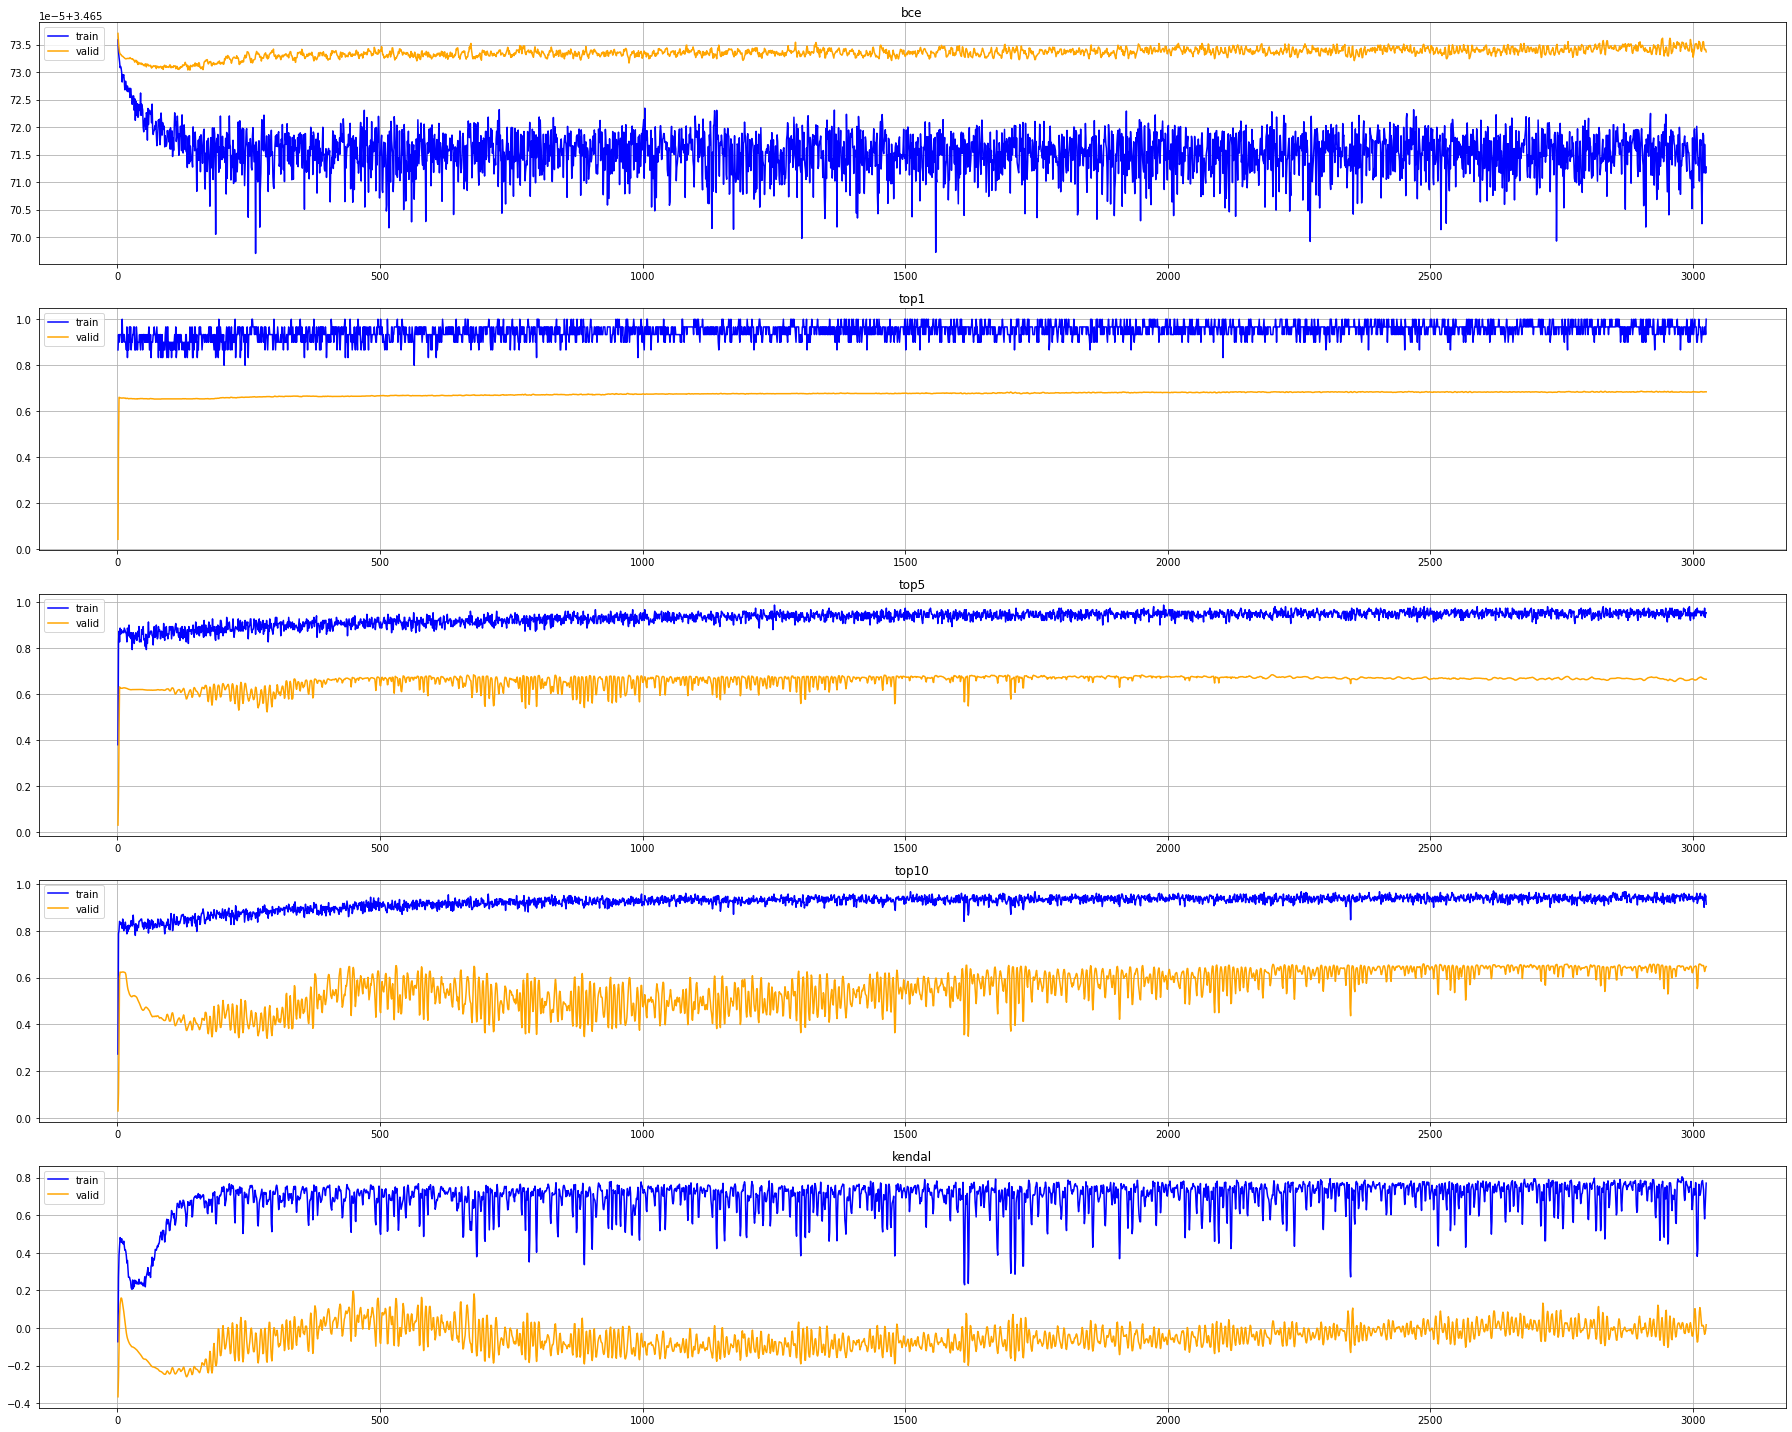

In [76]:
import matplotlib.pyplot as plt

with open(setting.train_info_p, 'r') as train_info, \
    open(setting.val_info_p, 'r') as valid_info:
    
    train = json.load(train_info)
    valid = json.load(valid_info)

    keys = list(train.keys())
    epochs = len(train[keys[0]])

    x = np.linspace(1, epochs, epochs)
    
    ### plot bce loss and mean top N %
    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        if key == "bce":
            y_train = [v/nodes_cnt for v in train[key]]
            y_valid = [v/5000 for v in valid[key]]
            ax.plot(x, y_train, color="blue")
            ax.plot(x, y_valid, color="orange")            
        else:
            ax.plot(x, train[key], color="blue")
            ax.plot(x, valid[key], color="orange")
        
        ax.legend(["train", "valid"], loc='upper left')
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(setting.result_plt_p, facecolor="white")

# Baseline

In [ ]:
import networkit as nk

In [ ]:
G = nk.readGraph("/hw1_data/Synthetic/5000/0.txt", nk.Format.EdgeListTabZero)

## RK (DIAM)

### ApproxBetweenness

In [ ]:
ab = nk.centrality.ApproxBetweenness(G, epsilon=0.1)
ab.run()

In [ ]:
# The 10 most central nodes according to betweenness are then 
ab.ranking()[:10]

## ARBA

## KADABRA

In [ ]:
# Initialize algorithm 
kadabra = nk.centrality.KadabraBetweenness(G, 0.05, 0.8) 
kadabra.run() 

In [ ]:
#The 10 most central nodes according to betweenness are then 
kadabra.ranking()[:10]

## K-BC (KPATH)

In [ ]:
kbc = nk.centrality.KPathCentrality(G, alpha=0.2, k=0)
kbc.run()

In [ ]:
kbc.ranking()[:10]